In [1]:
import pickle
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
from dataclasses import dataclass

from pyutils.pyprint import Print
from pyutils.pylogger import Logger
from pyutils.pyselect import Select
from pyutils.pycut import CutManager
from pyutils.pyplot import Plot
from pyutils.pyvector import Vector

import sys
sys.path.extend(["../../src/utils"])
from io_manager import Load

# Make everything available when using "from preamble import *"
__all__ = ["Logger", "Print", "Load", "Draw"] 

printer = Print()
selector = Select()
logger = Logger()
plotter = Plot()
vector = Vector()

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
[pyvector] ⭐️ Initialised Vector with verbosity = 1


In [2]:
@dataclass
class MomentumWindow:
    """Define momentum selection windows for track momentum"""
    name: str
    p_min: Optional[float] = None
    p_max: Optional[float] = None
    
    def apply(self, mom_mag):
        """Apply momentum cuts"""
        if self.p_min is None and self.p_max is None:
            return ak.ones_like(mom_mag, dtype=bool)
        
        mask = ak.ones_like(mom_mag, dtype=bool)
        if self.p_min is not None:
            mask = mask & (mom_mag > self.p_min)
        if self.p_max is not None:
            mask = mask & (mom_mag < self.p_max)
        return mask


class CosmicAna:
    """Pipeline for cosmic ray momentum analysis with livetime weighting"""

    # Livetime for each window (seconds)
    LIVETIMES = {
        "inclusive": {"aw": 35189, "1a": 14954},
        "wide": {"aw": 28048, "1a": 11800},
        "extended": {"aw": 2941, "1a": 1218},
        "signal": {"aw": 383.89, "1a": 159.59},
    }
    
    # Momentum windows (MeV/c) - applied to TRACK momentum at TT_Front
    WINDOWS = {
        "inclusive": MomentumWindow("inclusive"),
        "wide": MomentumWindow("wide", p_min=85, p_max=200),
        "extended": MomentumWindow("extended", p_min=100, p_max=110),
        "signal": MomentumWindow("signal", p_min=103.6, p_max=104.9),
    }
    
    # Plot styling
    DATASET_STYLES = {
        "aw": {"color": "red", "label": "Run-1 (MDC2020aw)"},
        "1a": {"color": "blue", "label": "Run-1a (MDC2025)"},
    }
    
    def __init__(self, data: Dict):
        self.data = data

    @classmethod
    def load_data(cls, base_path="../../output/results"):
        """Load data from default paths"""
        return {
            "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
            "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
        }
    
    # --- Event selection ---
    def _select_by_window(self, data, window_name: str):
        """
        Select events based on track momentum window at TT_Front
        
        This is the correct approach from your original select_window() function:
        1. Get track momentum at TT_Front
        2. Apply momentum window cuts to select events
        3. Filter all data structures by those cuts
        4. Return filtered data
        
        Returns: filtered data dict with only events passing window cuts
        """
        # Get track momentum at TT_Front surface
        trk_front = selector.select_surface(data["trkfit"], "TT_Front")
        mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
        mom_mag = mom_mag[trk_front]
        
        # Apply window cuts to track momentum
        window = self.WINDOWS[window_name]
        window_mask = window.apply(mom_mag)
        window_mask = ak.flatten(window_mask, axis=-1)
        
        # Apply mask to select events
        selected_data = {
            "trk": data["trk"][window_mask],
            "trkfit": data["trkfit"][window_mask],
            "trkmc": data["trkmc"][window_mask],
        }
        
        # Keep only events with tracks
        has_trks = ak.any(selected_data["trk"]["trk.pdg"], axis=-1)
        for key in selected_data:
            selected_data[key] = selected_data[key][has_trks]
        
        return selected_data
    
    # --- Parent momentum extraction ---
    def _get_parent_mom(self, parents) -> ak.Array:
        """Extract momentum magnitude from parents"""
        mom_mag = vector.get_mag(parents, "mom")
        mom_mag = ak.firsts(mom_mag, axis=-1)
        mom_mag = ak.flatten(mom_mag, axis=None)
        return mom_mag
    
    def _get_cosmic_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
        """Get cosmic parents (rank == -1)"""
        rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
        
        if pdg:
            pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
            condition = rank_mask & pdg_mask
        else:
            condition = rank_mask
        
        return data["trkmc"]["trkmcsim"][condition]
    
    def _get_track_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
        """Get track parents (max nhits)"""
        nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == \
                     ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        
        if pdg:
            pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
            condition = nhits_mask & pdg_mask
        else:
            condition = nhits_mask
        
        return data["trkmc"]["trkmcsim"][condition]
    
    def get_cosmic_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
        """Extract cosmic parent momentum magnitudes"""
        cosmic_parents = self._get_cosmic_parents(data, pdg)
        return self._get_parent_mom(cosmic_parents)
    
    def get_track_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
        """Extract track parent momentum magnitudes"""
        track_parents = self._get_track_parents(data, pdg)
        return self._get_parent_mom(track_parents)
    
    def _create_weights(self, n_events: int, livetime: float) -> np.ndarray:
        """Create weights array: 1/livetime for each event"""
        return np.ones(n_events) / livetime
    
    # --- Main pipeline ---
    def run(self, pdg: Optional[int] = None, windows: list = None, 
            convert_to_gev: bool = True) -> Dict:
        """
        Run full analysis pipeline
        
        Workflow:
        1. For each dataset and window:
        2. Select events based on TRACK momentum at TT_Front passing window cuts
        3. Extract PARENT momenta from selected events
        4. Create livetime weights
        
        Args:
            pdg: Particle PDG code to filter (e.g., 13 for muons)
            windows: List of window names to process (default: all)
            convert_to_gev: Convert momenta from MeV to GeV
        
        Returns:
            Nested dict: {dataset: {window: {parent_type: {mom, weights}}}}
        """
        if windows is None:
            windows = list(self.WINDOWS.keys())
        
        results = {}
        
        for dataset_name, dataset in self.data.items():
            print(f"\nProcessing dataset: {dataset_name}")
            results[dataset_name] = {}
            
            # Apply each window
            for window_name in windows:
                print(f"\tApplying {window_name} window...")
                
                # CRITICAL: Select events based on TRACK momentum at TT_Front
                selected_data = self._select_by_window(dataset, window_name)
                
                # Extract parent momenta from SELECTED events
                # (parent momenta can be any value - not constrained by window)
                cosmic_mom = self.get_cosmic_parent_mom(selected_data, pdg=pdg)
                track_mom = self.get_track_parent_mom(selected_data, pdg=pdg)
                
                # Convert to numpy
                cosmic_mom_np = ak.to_numpy(cosmic_mom)
                track_mom_np = ak.to_numpy(track_mom)
                
                # Optional: convert MeV -> GeV
                if convert_to_gev:
                    cosmic_mom_np = cosmic_mom_np * 1e-3
                    track_mom_np = track_mom_np * 1e-3
                
                # Get livetime for this window/dataset
                livetime = self.LIVETIMES[window_name][dataset_name]
                
                # Create weights: 1/livetime per event
                cosmic_weights = self._create_weights(len(cosmic_mom_np), livetime)
                track_weights = self._create_weights(len(track_mom_np), livetime)
                
                results[dataset_name][window_name] = {
                    "cosmic": {
                        "mom": cosmic_mom_np,
                        "weights": cosmic_weights,
                        "n_events": len(cosmic_mom_np),
                    },
                    "track": {
                        "mom": track_mom_np,
                        "weights": track_weights,
                        "n_events": len(track_mom_np),
                    },
                    "livetime": livetime,
                }
        
        return results

    @classmethod
    def plot_mom_overlays(cls, results, name="cosmic", nbins=160, xrange=(0, 40)): 
        """
        Plot 2x2 grid of momentum overlays for all windows
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
        """
        plotter = Plot()

        fig, ax = plt.subplots(2, 2, figsize=(2*1.25*6.4, 2*1.25*4.8)) 

        for i, window_name in enumerate(cls.WINDOWS.keys()): 

            mom_1a = results["1a"][window_name][name]["mom"]
            mom_aw = results["aw"][window_name][name]["mom"]
            
            xmin, xmax = xrange # 0, 40

            stats_aw = plotter.get_stats(mom_aw, xmin, xmax)
            stats_1a = plotter.get_stats(mom_1a, xmin, xmax)

            this_ax = ax[i // 2, i % 2]
    
            plotter.plot_1D_overlay(
                { 
                    r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]:.1f}\nStd Dev: {stats_aw[3]:.1f}": 
                        mom_aw,
                    
                    r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]:.1f}\nStd Dev: {stats_1a[3]:.1f}": 
                        mom_1a,
                },
                nbins=nbins,
                xmin=xmin, # xrange[0], 
                xmax=xmax, # xrange[1],
                # xlabel="Momentum [GeV/c]",
                xlabel=f"{name.capitalize()} parent momentum [GeV/c]",
                ylabel=f"Selected tracks",
                title=f"{window_name.capitalize()} window",
                log_y=True,
                show=False,
                ax=this_ax
            )

            title = f"{window_name.capitalize()} window"
            this_ax.set_title(title, fontsize=18)

        plt.tight_layout() 
        
        out_path = "../../output/images/energy_loss/"
        
        file_name = out_path + f"h1o_{name}_parent_mom.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()

    @classmethod
    def plot_rate_overlays(cls, results, name="cosmic", nbins=160, xrange=(0, 40)): 
        """
        Plot 2x2 grid of momentum rate overlays (weighted by livetime) for all windows
        
        Y-axis shows rate (events/day) instead of raw counts
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
            nbins: Number of histogram bins
            xrange: (min, max) momentum range in GeV
        """
        plotter = Plot()
        fig, ax = plt.subplots(2, 2, figsize=(2*1.25*6.4, 2*1.25*4.8)) 
        
        for i, window_name in enumerate(cls.WINDOWS.keys()): 
            mom_1a = results["1a"][window_name][name]["mom"]
            mom_aw = results["aw"][window_name][name]["mom"]
            
            # Get weights for rate calculation
            weights_1a = results["1a"][window_name][name]["weights"]
            weights_aw = results["aw"][window_name][name]["weights"]
            
            xmin, xmax = xrange
            
            # Stats on unweighted data
            stats_aw = plotter.get_stats(mom_aw, xmin, xmax)
            stats_1a = plotter.get_stats(mom_1a, xmin, xmax)
            
            this_ax = ax[i // 2, i % 2]

            plotter.plot_1D_overlay(
                { 
                    r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]:.1f}\nStd Dev: {stats_aw[3]:.1f}": 
                        mom_aw,
                    
                    r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]:.1f}\nStd Dev: {stats_1a[3]:.1f}": 
                        mom_1a,
                },
                weights=[weights_aw, weights_1a],
                nbins=nbins,
                xmin=xmin,
                xmax=xmax,
                # xlabel="Momentum [GeV/c]",
                xlabel=f"{name.capitalize()} parent momentum [GeV/c]", #  of selected tracks",
                ylabel=f"Rate [selected tracks / day]",
                # title=f"{window_name.capitalize()} window",
                log_y=True,
                show=False,
                ax=this_ax
            )

            title = f"{window_name.capitalize()} window"
            this_ax.set_title(title, fontsize=18)
        
        plt.tight_layout() 
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"h1o_{name}_parent_mom_rate.png"
        plt.savefig(file_name) # , dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()

    @classmethod
    def plot_rate_ratios(cls, results, name="cosmic", nbins=160, xrange=(0, 40)):
        """
        Plot 2x2 grid with rate overlays and ratio plots underneath each
        
        Each window gets:
        - Top panel: weighted rate overlay (aw vs 1a)
        - Bottom panel: ratio plot (aw/1a)
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
            nbins: Number of histogram bins
            xrange: (min, max) momentum range in GeV
        """
        from matplotlib.gridspec import GridSpec
        
        fig = plt.figure(figsize=(2*1.5*6.4, 2*1.5*4.8))
        
        # Create 4x4 grid (2x2 windows, each with 2 height units for overlay + ratio)
        # gs = GridSpec(4, 2, figure=fig, height_ratios=[3, 1, 3, 1], hspace=0.05, wspace=0.5)
        # Create grid with spacer row: [overlay, ratio, SPACER, overlay, ratio]
        gs = GridSpec(5, 2, figure=fig, height_ratios=[3, 1, 0.3, 3, 1], 
                    hspace=0.15, wspace=0.25, left=0.08, right=0.98, top=0.96, bottom=0.06)
    

        xmin, xmax = xrange
        
        for i, window_name in enumerate(cls.WINDOWS.keys()):
            # Calculate grid position (skip row 2 which is spacer)
            col = i % 2
            if i < 2:  # Top row windows
                row_base = 0
            else:  # Bottom row windows
                row_base = 3  # Skip spacer at row 2
            
            # Create overlay and ratio subplots
            ax_overlay = fig.add_subplot(gs[row_base, col])
            ax_ratio = fig.add_subplot(gs[row_base + 1, col], sharex=ax_overlay)
            
            # Get data and weights
            mom_1a = results["1a"][window_name][name]["mom"]
            mom_aw = results["aw"][window_name][name]["mom"]
            weights_1a = results["1a"][window_name][name]["weights"]
            weights_aw = results["aw"][window_name][name]["weights"]

            # Calculate total rates (sum of weights)
            total_rate_aw = np.sum(weights_aw)
            total_rate_1a = np.sum(weights_1a)

            # Create weighted histograms
            hist_aw, bins = np.histogram(mom_aw, bins=nbins, range=xrange, weights=weights_aw)
            hist_1a, _ = np.histogram(mom_1a, bins=nbins, range=xrange, weights=weights_1a)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Overlay plot
            ax_overlay.step(bin_centers, hist_aw, where='mid', color='red', 
                        label=f'Run-1 (MDC2020aw)\nTotal rate: {total_rate_aw:.3f}/day')
            ax_overlay.step(bin_centers, hist_1a, where='mid', color='blue', 
                        label=f'Run-1a (MDC2025)\nTotal rate: {total_rate_1a:.3f}/day')
            ax_overlay.set_ylabel("Rate [selected tracks / day]")
            ax_overlay.set_title(f"{window_name.capitalize()} window", fontsize=18)
            ax_overlay.set_yscale('log')
            ax_overlay.legend()
            ax_overlay.tick_params(labelbottom=False)
            
            # Ratio plot
            ratio = np.divide(hist_aw, hist_1a, where=hist_1a != 0, out=np.ones_like(hist_aw))
            ax_ratio.step(bin_centers, ratio, where='mid', color='black')
            ax_ratio.axhline(y=1, color='gray', linestyle='--', linewidth=1)
            ax_ratio.set_xlabel(f"{name.capitalize()} parent momentum [GeV/c]")
            ax_ratio.set_ylabel("1/1a", loc="center")
            ax_ratio.set_xlim(xmin, xmax)
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"h1o_{name}_parent_mom_rate_ratio.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")

        plt.show()
    
    # @classmethod
    # def analyze_ratio_slopes(cls, results, name="cosmic", nbins=160, xrange=(0, 40), 
    #                         plot=True, xfit_range=None):
    #     """
    #     Analyze the slope of ratio plots (aw/1a) vs momentum
        
    #     If shielding differences explain the rate difference, we might expect:
    #     - Flat ratio ~1: Both datasets behave similarly across momentum
    #     - Positive slope: aw rate increases more at high momentum
    #     - Negative slope: aw rate increases more at low momentum
        
    #     Args:
    #         results: Output from run()
    #         name: "cosmic" or "track"
    #         nbins: Number of histogram bins
    #         xrange: (min, max) momentum range in GeV
    #         plot: If True, create plot showing fits
    #         xfit_range: (min, max) momentum range for fit (default: use full xrange)
        
    #     Returns:
    #         Dict with slopes, intercepts, and fit statistics for each window
    #     """
    #     from scipy import stats
        
    #     xmin, xmax = xrange
    #     if xfit_range is None:
    #         xfit_min, xfit_max = xmin, xmax
    #     else:
    #         xfit_min, xfit_max = xfit_range
        
    #     fit_results = {}
        
    #     for window_name in cls.WINDOWS.keys():
    #         # Get data and weights
    #         mom_1a = results["1a"][window_name][name]["mom"]
    #         mom_aw = results["aw"][window_name][name]["mom"]
    #         weights_1a = results["1a"][window_name][name]["weights"]
    #         weights_aw = results["aw"][window_name][name]["weights"]
            
    #         # Create weighted histograms
    #         hist_aw, bins = np.histogram(mom_aw, bins=nbins, range=xrange, weights=weights_aw)
    #         hist_1a, _ = np.histogram(mom_1a, bins=nbins, range=xrange, weights=weights_1a)
    #         bin_centers = (bins[:-1] + bins[1:]) / 2
            
    #         # Calculate ratio
    #         ratio = np.divide(hist_aw, hist_1a, where=hist_1a != 0, 
    #                          out=np.nan*np.ones_like(hist_aw))
            
    #         # Select bins in fit range and with valid data
    #         fit_mask = (bin_centers >= xfit_min) & (bin_centers <= xfit_max) & \
    #                    (hist_1a > 0) & (hist_aw > 0) & np.isfinite(ratio)
            
    #         x_fit = bin_centers[fit_mask]
    #         y_fit = ratio[fit_mask]
            
    #         # Linear regression using scipy
    #         if len(x_fit) > 2:  # Need at least 3 points for meaningful fit
    #             try:
    #                 # scipy.stats.linregress returns: slope, intercept, r_value, p_value, std_err
    #                 linreg = stats.linregress(x_fit, y_fit)
                    
    #                 slope = linreg.slope
    #                 intercept = linreg.intercept
    #                 slope_uncertainty = linreg.stderr
    #                 r_squared = linreg.rvalue**2
    #                 p_value = linreg.pvalue
                    
    #                 # Calculate chi-squared for goodness of fit
    #                 y_pred = slope * x_fit + intercept
    #                 residuals = y_fit - y_pred
    #                 chi2 = np.sum(residuals**2)
    #                 ndof = len(x_fit) - 2
    #                 chi2_per_ndof = chi2 / ndof if ndof > 0 else np.nan
                    
    #                 fit_results[window_name] = {
    #                     'slope': slope,
    #                     'slope_uncertainty': slope_uncertainty,
    #                     'intercept': intercept,
    #                     'r_squared': r_squared,
    #                     'p_value': p_value,
    #                     'chi2_per_ndof': chi2_per_ndof,
    #                     'bin_centers': bin_centers,
    #                     'ratio': ratio,
    #                     'x_fit': x_fit,
    #                     'y_fit': y_fit,
    #                     'fit_line': slope * x_fit + intercept,
    #                     'n_fit_points': len(x_fit)
    #                 }
    #             except Exception as e:
    #                 print(f"Warning: Fit failed for {window_name}: {e}")
    #                 fit_results[window_name] = None
    #         else:
    #             fit_results[window_name] = None
        
    #     # Print results
    #     print("\n" + "="*90)
    #     print(f"Ratio Slope Analysis: {name} parents")
    #     print("="*90)
    #     print(f"Fit range: {xfit_min:.1f} - {xfit_max:.1f} GeV/c")
    #     print("-"*90)
    #     print(f"{'Window':<12} {'N pts':<8} {'Slope':<20} {'Intercept':<10} {'R²':<8} {'p-value':<10}")
    #     print("-"*90)
        
    #     for window_name, result in fit_results.items():
    #         if result is not None:
    #             slope_str = f"{result['slope']:.4e} ± {result['slope_uncertainty']:.2e}"
    #             print(f"{window_name:<12} {result['n_fit_points']:<8} {slope_str:<20} "
    #                   f"{result['intercept']:<10.3f} {result['r_squared']:<8.4f} {result['p_value']:<10.3e}")
    #         else:
    #             print(f"{window_name:<12} {'Insufficient data or fit failed'}")
    #     print("="*90)
        
    #     # Interpretation
    #     print("\nInterpretation:")
    #     print("- Slope ≈ 0 (with high p-value): Ratio is flat → both datasets scale similarly")
    #     print("- Slope > 0 (significant): Ratio increases with momentum")
    #     print("- Slope < 0 (significant): Ratio decreases with momentum")
    #     print("- R² close to 1: Linear model fits data well")
    #     print("- p-value < 0.05: Slope is statistically significant")
    #     print()
        
    #     # Optional: Create plot
    #     if plot:
    #         fig, axes = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))
            
    #         for i, window_name in enumerate(cls.WINDOWS.keys()):
    #             ax = axes[i // 2, i % 2]
    #             result = fit_results[window_name]
                
    #             if result is not None:
    #                 # Plot ratio data as line graph
    #                 ax.plot(result['bin_centers'], result['ratio'], 
    #                        color='black', marker='o', markersize=3, linewidth=0,
    #                        label='Data', alpha=0.7)
                    
    #                 # Plot fit
    #                 significance = "***" if result['p_value'] < 0.001 else \
    #                               "**" if result['p_value'] < 0.01 else \
    #                               "*" if result['p_value'] < 0.05 else "n.s."
                    
        #             ax.plot(result['x_fit'], result['fit_line'], 'r-', linewidth=2,
        #                    label=f"Fit: y = ({result['slope']:.2e} ± {result['slope_uncertainty']:.2e})x + {result['intercept']:.2f}\n"
        #                          r"$\chi^{2}/\text{ndf} = $" + f"{result['chi2_per_ndof']:.3f}, p = {result['p_value']:.2e}") # {significance}")
                    
        #             # Horizontal line at 1
        #             ax.axhline(y=1, color='gray', linestyle='--', linewidth=1.5) # , alpha=0.5)
                    
        #             ax.set_xlabel(f"{name.capitalize()} parent momentum [GeV/c]")
        #             ax.set_ylabel("Ratio (1/1a)")
        #             ax.set_title(f"{window_name.capitalize()} window")
        #             ax.set_xlim(xmin, xmax)
        #             ax.legend() # fontsize=8)
        #             # ax.grid(alpha=0.3)
        #         else:
        #             ax.text(0.5, 0.5, 'Insufficient data\nor fit failed', 
        #                    ha='center', va='center', transform=ax.transAxes)
        #             ax.set_title(f"{window_name.capitalize()} window")
            
        #     plt.tight_layout()
            
        #     out_path = "../../output/images/energy_loss/"
        #     file_name = out_path + f"h1o_{name}_ratio_slope_analysis.png"
        #     plt.savefig(file_name, dpi=300, bbox_inches='tight')
        #     print(f"Saved plot: {file_name}")
            
        #     plt.show()
        
        # return fit_results

    @classmethod
    def analyze_ratio_slopes(cls, results, name="cosmic", nbins=160, xrange=(0, 40), 
                            plot=True, xfit_range=None):
        """
        Analyze the slope of ratio plots (aw/1a) vs momentum
        
        If shielding differences explain the rate difference, we might expect:
        - Flat ratio ~1: Both datasets behave similarly across momentum
        - Positive slope: aw rate increases more at high momentum
        - Negative slope: aw rate increases more at low momentum
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
            nbins: Number of histogram bins
            xrange: (min, max) momentum range in GeV
            plot: If True, create plot showing fits
            xfit_range: (min, max) momentum range for fit (default: use full xrange)
        
        Returns:
            Dict with slopes, intercepts, and fit statistics for each window
        """
        from scipy import stats
        
        xmin, xmax = xrange
        if xfit_range is None:
            xfit_min, xfit_max = xmin, xmax
        else:
            xfit_min, xfit_max = xfit_range
        
        fit_results = {}
        
        for window_name in cls.WINDOWS.keys():
            # Get data and weights
            mom_1a = results["1a"][window_name][name]["mom"]
            mom_aw = results["aw"][window_name][name]["mom"]
            weights_1a = results["1a"][window_name][name]["weights"]
            weights_aw = results["aw"][window_name][name]["weights"]
            
            # Create weighted histograms
            hist_aw, bins = np.histogram(mom_aw, bins=nbins, range=xrange, weights=weights_aw)
            hist_1a, _ = np.histogram(mom_1a, bins=nbins, range=xrange, weights=weights_1a)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Calculate uncertainties for weighted histograms
            # For uniform weights w, uncertainty = sqrt(N * w^2) = w * sqrt(N)
            # where N = bin_content / w
            w_aw = weights_aw[0] if len(weights_aw) > 0 else 1
            w_1a = weights_1a[0] if len(weights_1a) > 0 else 1
            
            # Uncertainty on each bin (Poisson errors propagated through weighting)
            err_aw = np.sqrt(hist_aw * w_aw)
            err_1a = np.sqrt(hist_1a * w_1a)
            
            # Calculate ratio
            ratio = np.divide(hist_aw, hist_1a, where=hist_1a != 0, 
                             out=np.nan*np.ones_like(hist_aw))
            
            # Uncertainty on ratio using error propagation: sigma_R = R * sqrt((sigma_A/A)^2 + (sigma_B/B)^2)
            ratio_err = np.abs(ratio) * np.sqrt(
                np.divide(err_aw**2, hist_aw**2, where=hist_aw > 0, out=np.zeros_like(hist_aw)) +
                np.divide(err_1a**2, hist_1a**2, where=hist_1a > 0, out=np.zeros_like(hist_1a))
            )
            
            # Select bins in fit range and with valid data
            fit_mask = (bin_centers >= xfit_min) & (bin_centers <= xfit_max) & \
                       (hist_1a > 0) & (hist_aw > 0) & np.isfinite(ratio)
            
            x_fit = bin_centers[fit_mask]
            y_fit = ratio[fit_mask]
            y_err_fit = ratio_err[fit_mask]
            
            # Linear regression using scipy
            if len(x_fit) > 2:  # Need at least 3 points for meaningful fit
                try:
                    # scipy.stats.linregress returns: slope, intercept, r_value, p_value, std_err
                    linreg = stats.linregress(x_fit, y_fit)
                    
                    slope = linreg.slope
                    intercept = linreg.intercept
                    slope_uncertainty = linreg.stderr
                    r_squared = linreg.rvalue**2
                    p_value = linreg.pvalue
                    
                    # Calculate chi-squared for goodness of fit
                    y_pred = slope * x_fit + intercept
                    residuals = y_fit - y_pred
                    chi2 = np.sum(residuals**2)
                    ndof = len(x_fit) - 2
                    chi2_per_ndof = chi2 / ndof if ndof > 0 else np.nan
                    
                    fit_results[window_name] = {
                        'slope': slope,
                        'slope_uncertainty': slope_uncertainty,
                        'intercept': intercept,
                        'r_squared': r_squared,
                        'p_value': p_value,
                        'chi2_per_ndof': chi2_per_ndof,
                        'bin_centers': bin_centers,
                        'ratio': ratio,
                        'ratio_err': ratio_err,
                        'x_fit': x_fit,
                        'y_fit': y_fit,
                        'y_err_fit': y_err_fit,
                        'fit_line': slope * x_fit + intercept,
                        'n_fit_points': len(x_fit)
                    }
                except Exception as e:
                    print(f"Warning: Fit failed for {window_name}: {e}")
                    fit_results[window_name] = None
            else:
                fit_results[window_name] = None
        
        # Print results
        print("\n" + "="*90)
        print(f"Ratio Slope Analysis: {name} parents")
        print("="*90)
        print(f"Fit range: {xfit_min:.1f} - {xfit_max:.1f} GeV/c")
        print("-"*90)
        print(f"{'Window':<12} {'N pts':<8} {'Slope':<20} {'Intercept':<10} {'R²':<8} {'p-value':<10}")
        print("-"*90)
        
        for window_name, result in fit_results.items():
            if result is not None:
                slope_str = f"{result['slope']:.4e} ± {result['slope_uncertainty']:.2e}"
                print(f"{window_name:<12} {result['n_fit_points']:<8} {slope_str:<20} "
                      f"{result['intercept']:<10.3f} {result['r_squared']:<8.4f} {result['p_value']:<10.3e}")
            else:
                print(f"{window_name:<12} {'Insufficient data or fit failed'}")
        print("="*90)
        
        # Interpretation
        print("\nInterpretation:")
        print("- Slope ≈ 0 (with high p-value): Ratio is flat → both datasets scale similarly")
        print("- Slope > 0 (significant): Ratio increases with momentum")
        print("- Slope < 0 (significant): Ratio decreases with momentum")
        print("- R² close to 1: Linear model fits data well")
        print("- p-value < 0.05: Slope is statistically significant")
        print()
        
        # Optional: Create plot
        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))
            
            for i, window_name in enumerate(cls.WINDOWS.keys()):
                ax = axes[i // 2, i % 2]
                result = fit_results[window_name]
                
                if result is not None:
                    # Plot ratio data with error bars
                    ax.errorbar(result['bin_centers'], result['ratio'], yerr=result['ratio_err'],
                               fmt='o', color='black', markersize=4, capsize=2, 
                               linewidth=0, elinewidth=1, label='Data', alpha=0.7)
                    
                    # Plot fit
                    significance = "***" if result['p_value'] < 0.001 else \
                                  "**" if result['p_value'] < 0.01 else \
                                  "*" if result['p_value'] < 0.05 else "n.s."
                    
                    ax.plot(result['x_fit'], result['fit_line'], 'r-', linewidth=2,
                           label=f"Fit: y = ({result['slope']:.2e} ± {result['slope_uncertainty']:.2e})x + {result['intercept']:.2f}\n"
                                 r"$\chi^{2}/\text{ndf} = $" + f"{result['chi2_per_ndof']:.3f}, p = {result['p_value']:.2e}")
                    
                    # Horizontal line at 1
                    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1.5)
                    
                    ax.set_xlabel(f"{name.capitalize()} parent momentum [GeV/c]")
                    ax.set_ylabel("Ratio of selection rates (1/1a)")
                    ax.set_title(f"{window_name.capitalize()} window")
                    ax.set_xlim(xmin, xmax)
                    ax.legend()
                else:
                    ax.text(0.5, 0.5, 'Insufficient data\nor fit failed', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f"{window_name.capitalize()} window")
            
            plt.tight_layout()
            
            out_path = "../../output/images/energy_loss/"
            file_name = out_path + f"h1o_{name}_ratio_slope_analysis.png"
            plt.savefig(file_name, dpi=300, bbox_inches='tight')
            print(f"Saved plot: {file_name}")
            
            plt.show()
        
        return fit_results

[Load] ✅ Initialised with out_path=../../output/results/dev_CRY_onspill-LH_1a_noCRV
[Load] ✅ Successfully loaded ak.Array from ../../output/results/dev_CRY_onspill-LH_1a_noCRV/events.parquet
[Load] ✅ Initialised with out_path=../../output/results/dev_CRY_onspill-LH_aw_noCRV
[Load] ✅ Successfully loaded ak.Array from ../../output/results/dev_CRY_onspill-LH_aw_noCRV/events.parquet
Running analysis pipeline...

Processing dataset: 1a
	Applying inclusive window...
[pyselect] ✅ Returning mask for trksegs with sid = 0
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
	Applying wide window...
[pyselect] ✅ Returning mask for trksegs with sid = 0
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 

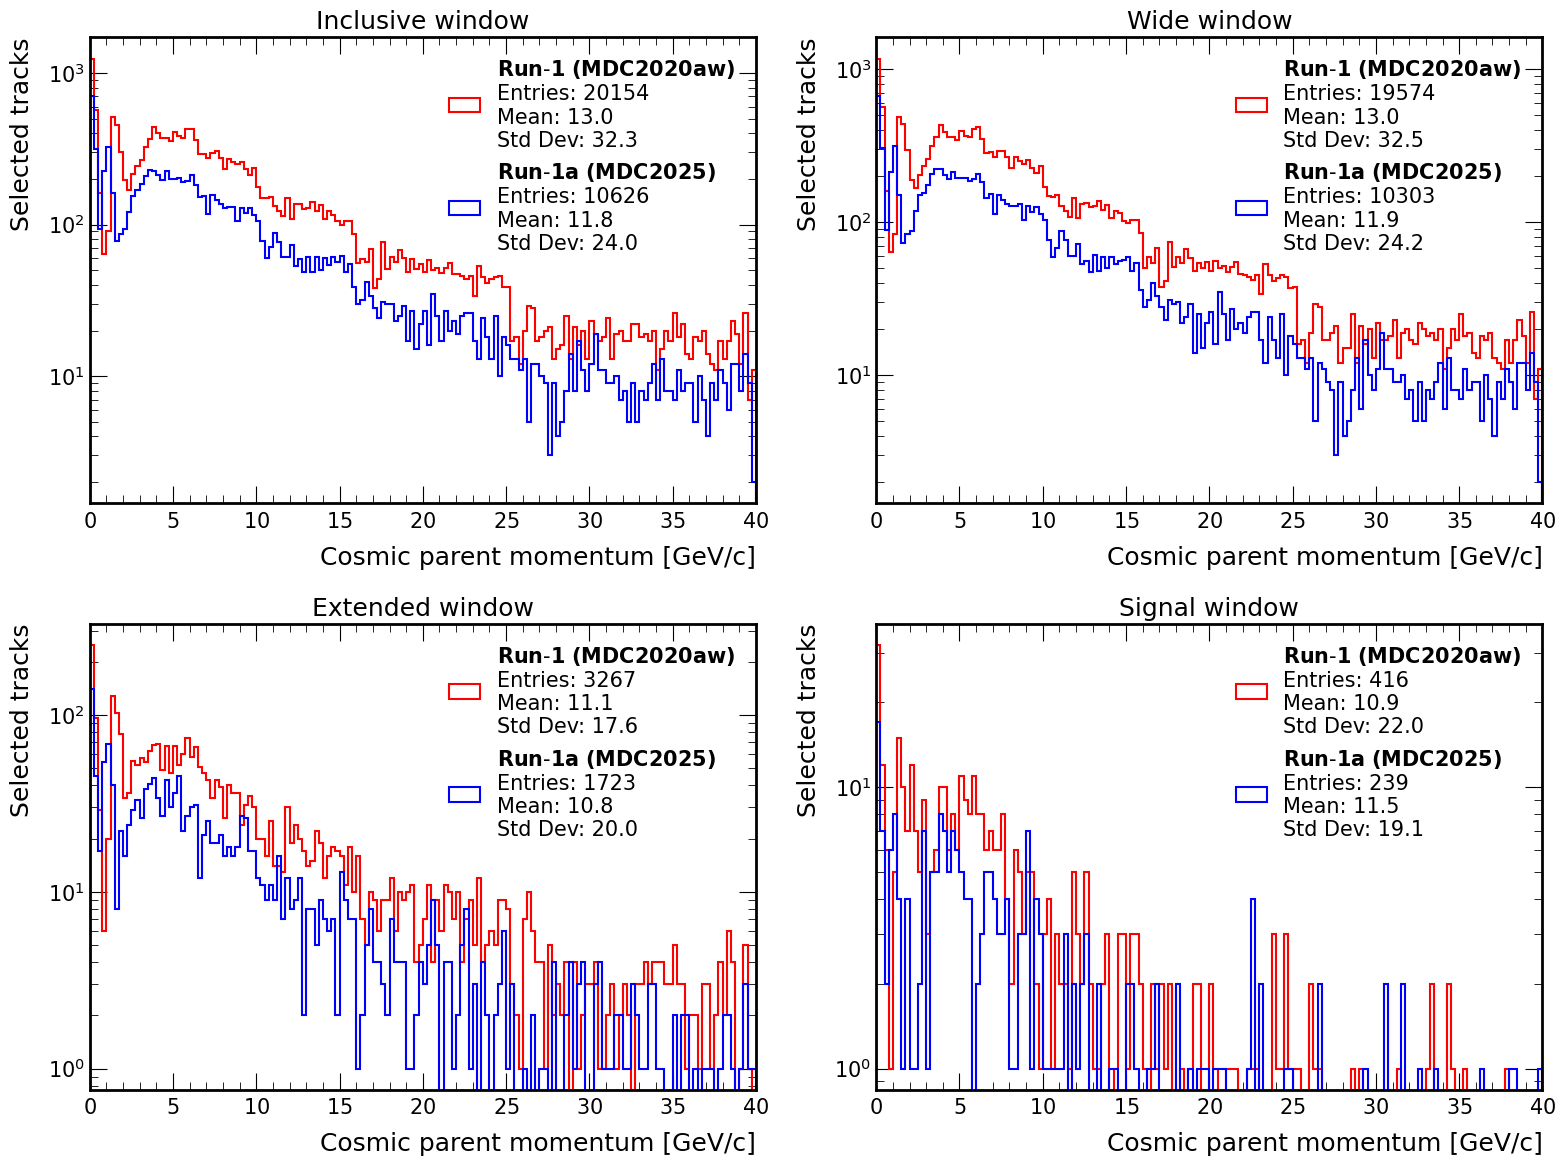


Plotting rate overlays...
[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
Wrote ../../output/images/energy_loss/h1o_cosmic_parent_mom_rate.png


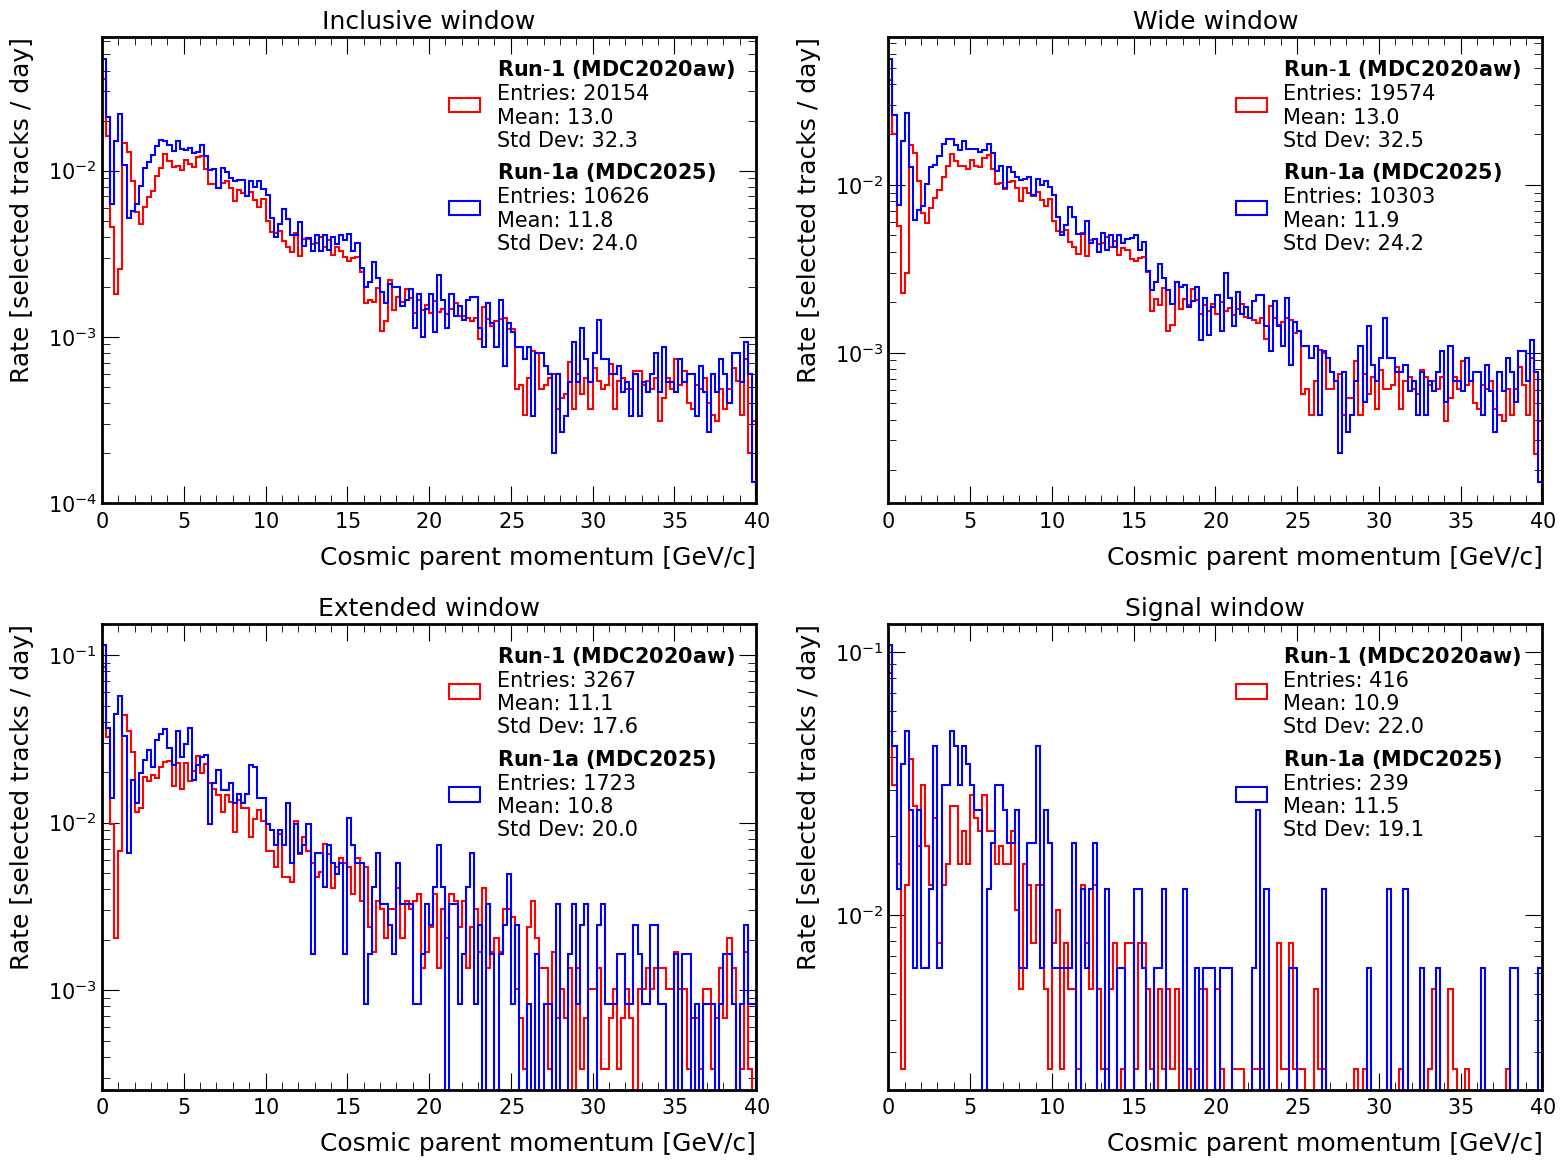


Plotting rate ratio overlays...
Wrote ../../output/images/energy_loss/h1o_cosmic_parent_mom_rate_ratio.png


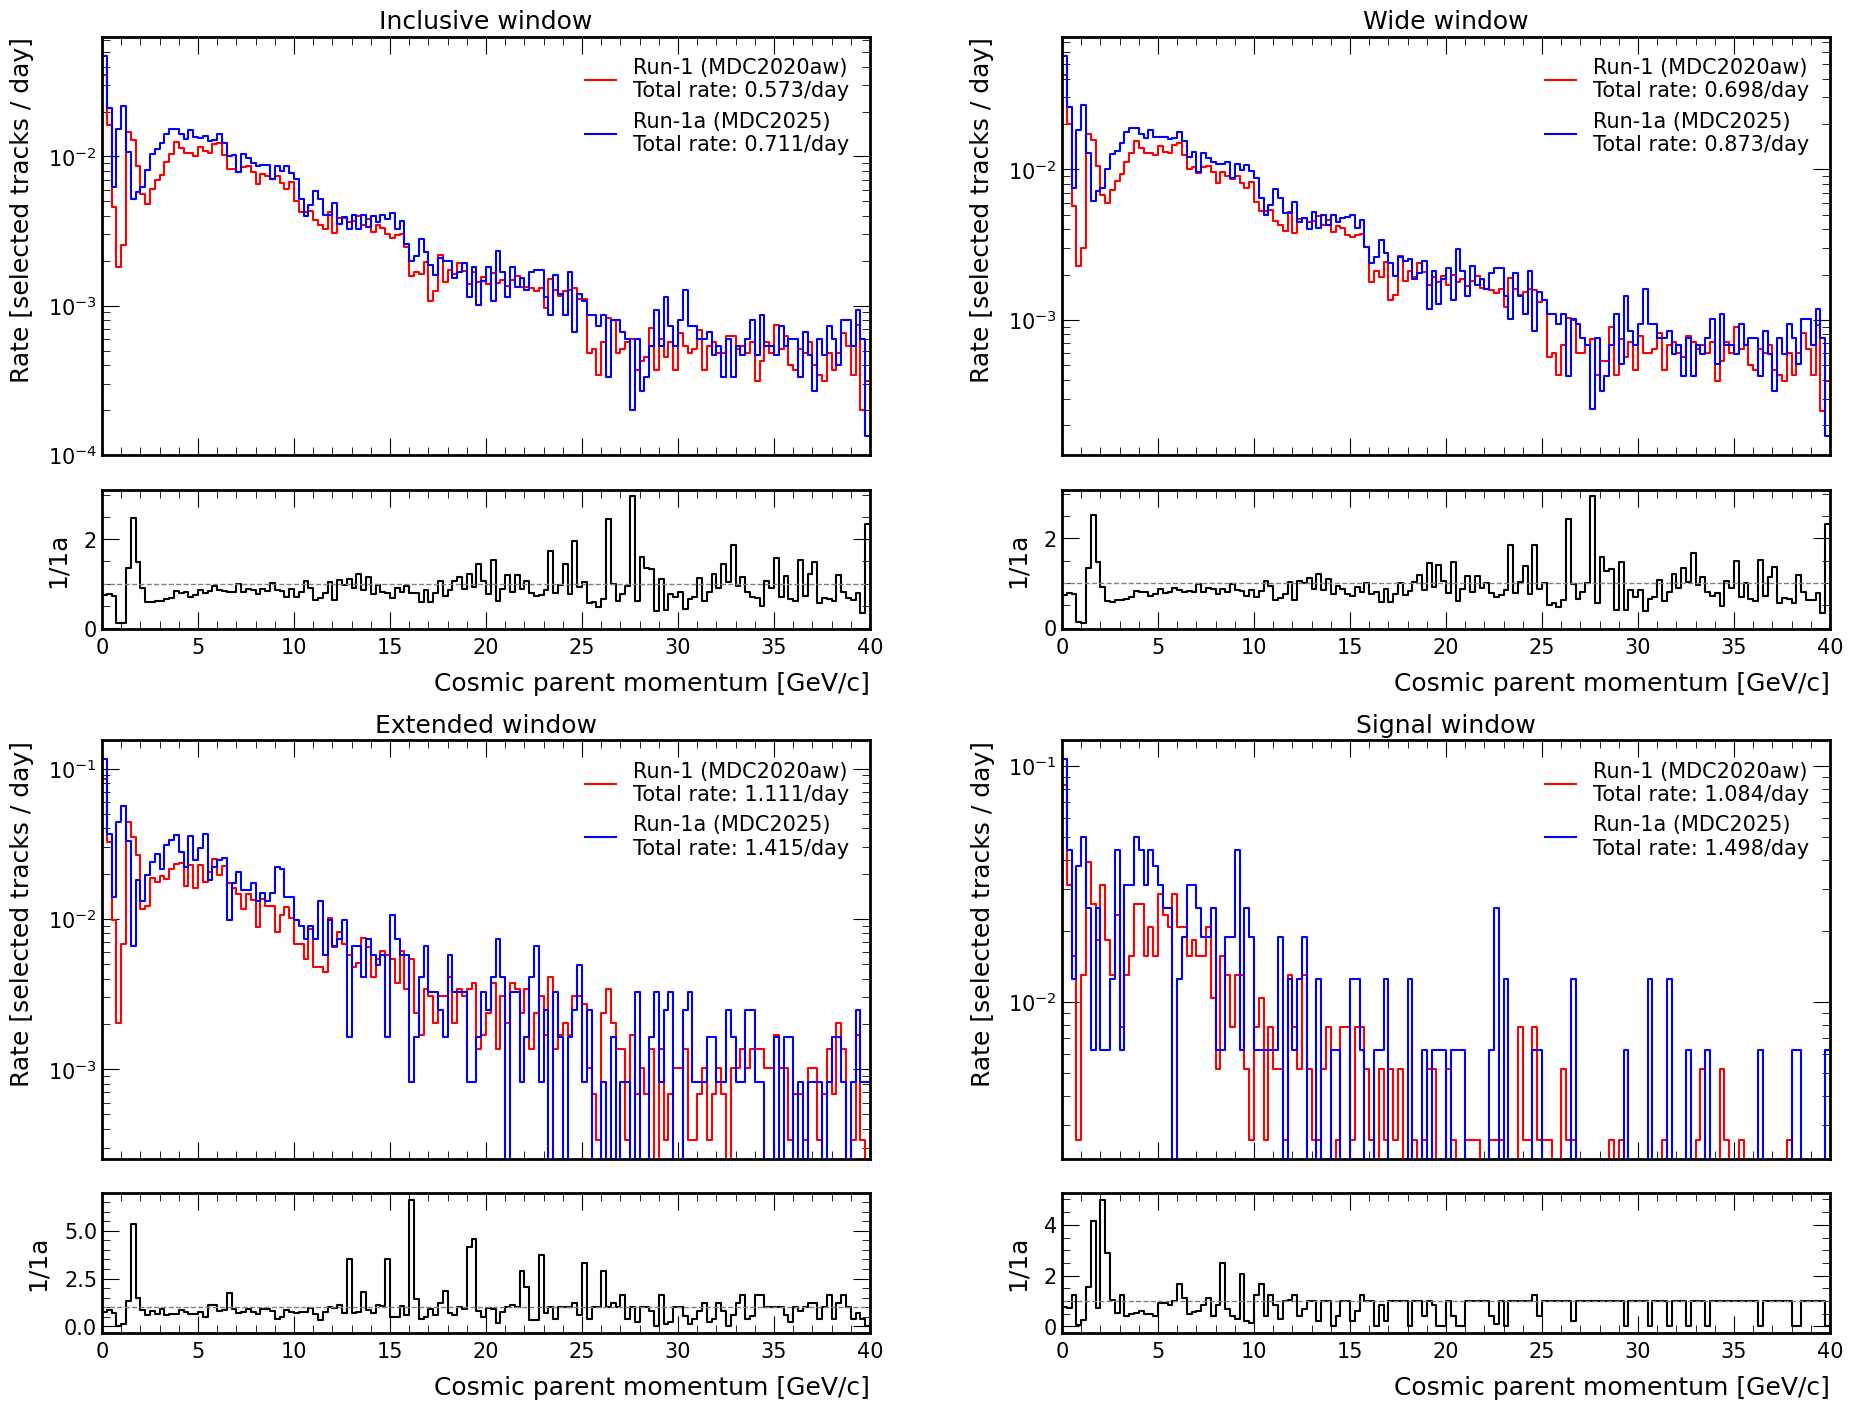


Plotting rate ratio overlays...

Ratio Slope Analysis: cosmic parents
Fit range: 0.0 - 40.0 GeV/c
------------------------------------------------------------------------------------------
Window       N pts    Slope                Intercept  R²       p-value   
------------------------------------------------------------------------------------------
inclusive    160      4.3785e-03 ± 2.70e-03 0.835      0.0164   1.067e-01 
wide         160      3.8639e-03 ± 2.67e-03 0.835      0.0130   1.505e-01 
extended     138      -7.9865e-04 ± 7.32e-03 1.077      0.0001   9.133e-01 
signal       64       -3.7380e-02 ± 1.58e-02 1.241      0.0830   2.094e-02 

Interpretation:
- Slope ≈ 0 (with high p-value): Ratio is flat → both datasets scale similarly
- Slope > 0 (significant): Ratio increases with momentum
- Slope < 0 (significant): Ratio decreases with momentum
- R² close to 1: Linear model fits data well
- p-value < 0.05: Slope is statistically significant

Saved plot: ../../output/images/en

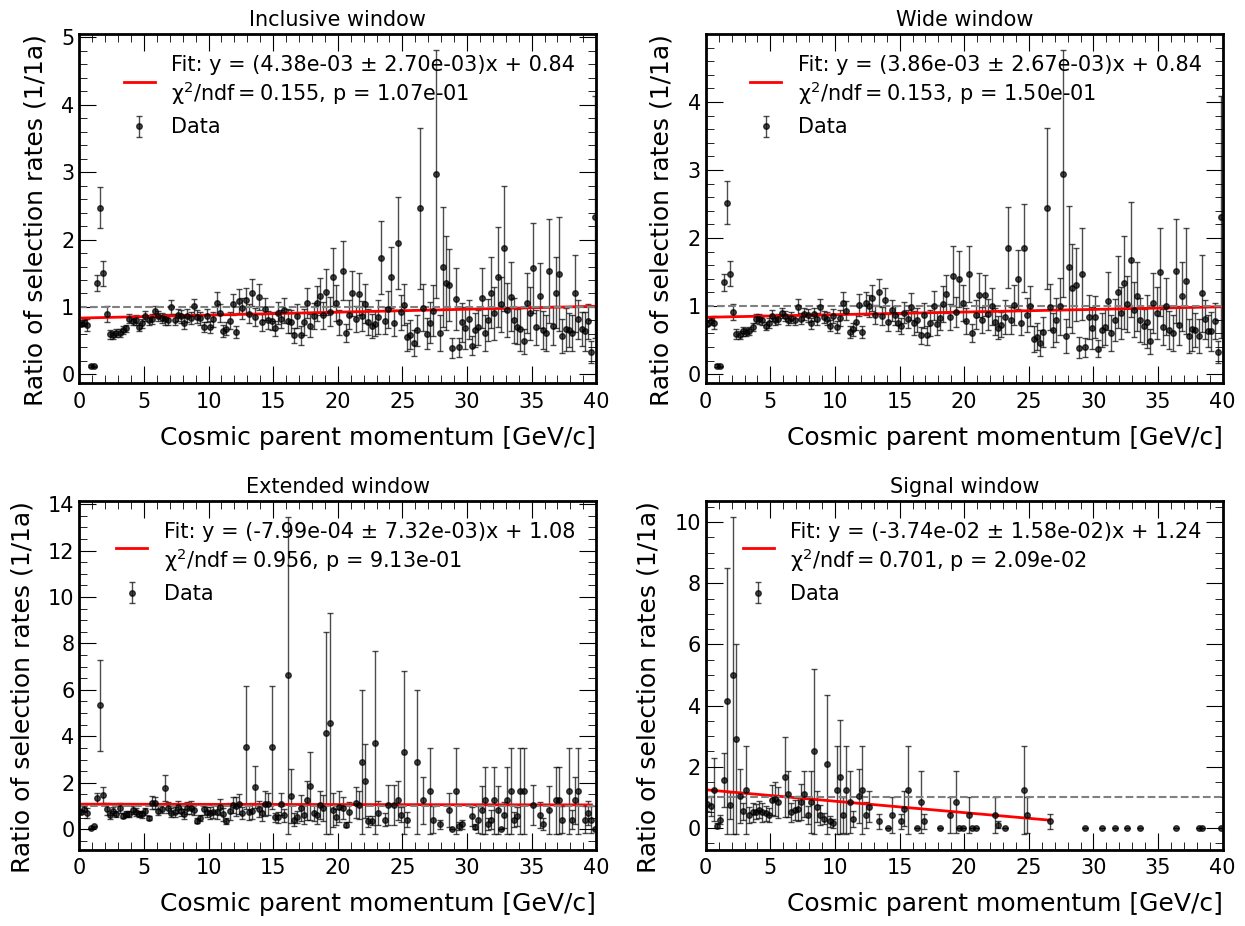

In [3]:
if __name__ == "__main__":
    # Load and run
    data = CosmicAna.load_data()
    analyzer = CosmicAna(data)
    
    # Run pipeline (pdg=None for all particles, or pdg=13 for muons only)
    print("Running analysis pipeline...")
    results = analyzer.run(pdg=None)
    
    # Print summary
    print("\n" + "="*60)
    print("Analysis Summary")
    print("="*60)
    for dataset in results:
        for window in results[dataset]:
            n_cosmic = results[dataset][window]["cosmic"]["n_events"]
            n_track = results[dataset][window]["track"]["n_events"]
            livetime = results[dataset][window]["livetime"]
            print(f"{dataset:>3} | {window:>9} | Cosmic: {n_cosmic:>5} | Track: {n_track:>5} | Livetime: {livetime:>8.2f}s")
    
    # Plot cosmic parents
    print("\nPlotting cosmic parent momenta...")
    CosmicAna.plot_mom_overlays(results)

    print("\nPlotting rate overlays...")
    CosmicAna.plot_rate_overlays(results)

    print("\nPlotting rate ratio overlays...")
    CosmicAna.plot_rate_ratios(results) 

    print("\nPlotting rate ratio overlays...")
    CosmicAna.analyze_ratio_slopes(results) 

In [4]:
# from typing import Dict, Tuple, Optional
# from dataclasses import dataclass
# import numpy as np
# import matplotlib.pyplot as plt

# @dataclass
# class MomentumWindow:
#     """Define momentum selection windows for track momentum"""
#     name: str
#     p_min: Optional[float] = None
#     p_max: Optional[float] = None


# class CosmicAna:
#     """Pipeline for cosmic ray momentum analysis with livetime weighting"""

#     # Livetime for each window (seconds)
#     LIVETIMES = {
#         "inclusive": {"aw": 35189, "1a": 14954},
#         "wide": {"aw": 28048, "1a": 11800},
#         "extended": {"aw": 2941, "1a": 1218},
#         "signal": {"aw": 383.89, "1a": 159.59},
#     }
    
#     # Momentum windows (MeV/c) - applied to TRACK momentum at TT_Front
#     WINDOWS = {
#         "inclusive": MomentumWindow("inclusive"),  # No cuts
#         "wide": MomentumWindow("wide", p_min=85, p_max=200),
#         "extended": MomentumWindow("extended", p_min=100, p_max=110),
#         "signal": MomentumWindow("signal", p_min=103.6, p_max=104.9),
#     }
    
#     # Plot styling
#     DATASET_STYLES = {
#         "aw": {"color": "red", "label": "Run-1 (MDC2020aw)"},
#         "1a": {"color": "blue", "label": "Run-1a (MDC2025)"},
#     }
    
#     def __init__(self, data: Dict):
#         self.data = data

#     @classmethod
#     def load_data(cls, base_path="../../output/results"):
#         """Load data from default paths"""
#         return {
#             "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#             "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#         }
    
#     # --- Event selection ---
#     def _select_by_window(self, data, window_name: str):
#         """
#         Select events based on track momentum window at TT_Front
#         Returns: filtered data with only events passing window cuts
#         """
#         # Get track momentum at TT_Front surface
#         trk_front = selector.select_surface(data["trkfit"], "TT_Front")
#         mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
#         mom_mag = mom_mag[trk_front]
        
#         # Apply window cuts to track momentum
#         window = self.WINDOWS[window_name]
#         if window.p_min is None and window.p_max is None:
#             # Inclusive: no cuts
#             window_mask = ak.ones_like(mom_mag, dtype=bool)
#         else:
#             window_mask = ak.ones_like(mom_mag, dtype=bool)
#             if window.p_min is not None:
#                 window_mask = window_mask & (mom_mag > window.p_min)
#             if window.p_max is not None:
#                 window_mask = window_mask & (mom_mag < window.p_max)
        
#         window_mask = ak.flatten(window_mask, axis=-1)
        
#         # Apply mask to select events
#         selected_data = {
#             "trk": data["trk"][window_mask],
#             "trkfit": data["trkfit"][window_mask],
#             "trkmc": data["trkmc"][window_mask],
#         }
        
#         # Keep only events with tracks
#         has_trks = ak.any(selected_data["trk"]["trk.pdg"], axis=-1)
#         for key in selected_data:
#             selected_data[key] = selected_data[key][has_trks]
        
#         return selected_data
    
#     # --- Parent momentum extraction ---
#     def _get_parent_mom(self, parents) -> ak.Array:
#         """Extract momentum magnitude from parents"""
#         mom_mag = vector.get_mag(parents, "mom")
#         mom_mag = ak.firsts(mom_mag, axis=-1)
#         mom_mag = ak.flatten(mom_mag, axis=None)
#         return mom_mag
    
#     def _get_cosmic_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get cosmic parents (rank == -1)"""
#         rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = rank_mask & pdg_mask
#         else:
#             condition = rank_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def _get_track_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get track parents (max nhits)"""
#         nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == \
#                      ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = nhits_mask & pdg_mask
#         else:
#             condition = nhits_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def get_cosmic_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract cosmic parent momentum magnitudes"""
#         cosmic_parents = self._get_cosmic_parents(data, pdg)
#         return self._get_parent_mom(cosmic_parents)
    
#     def get_track_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract track parent momentum magnitudes"""
#         track_parents = self._get_track_parents(data, pdg)
#         return self._get_parent_mom(track_parents)
    
#     def _create_weights(self, n_events: int, livetime: float) -> np.ndarray:
#         """Create weights array: 1/livetime for each event"""
#         return np.ones(n_events) / livetime
    
#     # --- Main pipeline ---
#     def run(self, pdg: Optional[int] = None, windows: list = None, 
#             convert_to_gev: bool = True) -> Dict:
#         """
#         Run full analysis pipeline
        
#         Workflow:
#         1. For each dataset and window:
#         2. Select events based on track momentum at TT_Front passing window cuts
#         3. Extract parent momenta from selected events
#         4. Create livetime weights
        
#         Args:
#             pdg: Particle PDG code to filter (e.g., 13 for muons)
#             windows: List of window names to process (default: all)
#             convert_to_gev: Convert momenta from MeV to GeV
        
#         Returns:
#             Nested dict: {dataset: {window: {parent_type: {mom, weights}}}}
#         """
#         if windows is None:
#             windows = list(self.WINDOWS.keys())
        
#         results = {}
        
#         for dataset_name, dataset in self.data.items():
#             print(f"\nProcessing dataset: {dataset_name}")
#             results[dataset_name] = {}
            
#             # Apply each window
#             for window_name in windows:
#                 print(f"  - Applying {window_name} window...")
                
#                 # Select events based on track momentum at TT_Front
#                 selected_data = self._select_by_window(dataset, window_name)
                
#                 # Extract parent momenta from selected events
#                 cosmic_mom = self.get_cosmic_parent_mom(selected_data, pdg=pdg)
#                 track_mom = self.get_track_parent_mom(selected_data, pdg=pdg)
                
#                 # Convert to numpy
#                 cosmic_mom_np = ak.to_numpy(cosmic_mom)
#                 track_mom_np = ak.to_numpy(track_mom)
                
#                 # Optional: convert MeV -> GeV
#                 if convert_to_gev:
#                     cosmic_mom_np = cosmic_mom_np * 1e-3
#                     track_mom_np = track_mom_np * 1e-3
                
#                 # Get livetime for this window/dataset
#                 livetime = self.LIVETIMES[window_name][dataset_name]
                
#                 # Create weights: 1/livetime per event
#                 cosmic_weights = self._create_weights(len(cosmic_mom_np), livetime)
#                 track_weights = self._create_weights(len(track_mom_np), livetime)
                
#                 results[dataset_name][window_name] = {
#                     "cosmic": {
#                         "mom": cosmic_mom_np,
#                         "weights": cosmic_weights,
#                         "n_events": len(cosmic_mom_np),
#                     },
#                     "track": {
#                         "mom": track_mom_np,
#                         "weights": track_weights,
#                         "n_events": len(track_mom_np),
#                     },
#                     "livetime": livetime,
#                 }
        
#         return results
    
#     # --- Plotting methods ---
#     def plot_window_comparison(self, results: Dict, window: str, parent_type: str,
#                                bins: int = 20, mom_range: Tuple[float, float] = (0, 40),
#                                log_scale: bool = True, ax: Optional[plt.Axes] = None) -> plt.Axes:
#         """
#         Plot momentum comparison for one window
        
#         Args:
#             results: Output from run()
#             window: Window name (e.g., "signal")
#             parent_type: "cosmic" or "track"
#             bins: Number of histogram bins
#             mom_range: (min, max) momentum range in GeV
#             log_scale: Use log scale for y-axis
#             ax: Matplotlib axes (creates new if None)
        
#         Returns:
#             Matplotlib axes object
#         """
#         if ax is None:
#             fig, ax = plt.subplots(figsize=(8, 6))
        
#         # Plot each dataset
#         for dataset_name in ["aw", "1a"]:  # Order matters for legend
#             data = results[dataset_name][window][parent_type]
#             style = self.DATASET_STYLES[dataset_name]
            
#             ax.hist(data["mom"], bins=bins, range=mom_range, 
#                    weights=data["weights"], histtype='step',
#                    label=style["label"], color=style["color"], linewidth=1.5)
        
#         # Styling
#         parent_label = "Cosmic" if parent_type == "cosmic" else "Track"
#         ax.set_xlabel('Momentum [GeV/c]', fontsize=12)
#         ax.set_ylabel('Selected tracks / day', fontsize=12)
#         ax.set_title(f'{parent_label} Parent Momentum - {window.capitalize()} Window', 
#                     fontsize=13)
        
#         if log_scale:
#             ax.set_yscale('log')
        
#         ax.legend(fontsize=10)
#         ax.grid(alpha=0.3)
        
#         return ax
    
#     def plot_all_windows(self, results: Dict, parent_type: str = "cosmic",
#                         bins: int = 20, mom_range: Tuple[float, float] = (0, 40),
#                         log_scale: bool = True, save_path: Optional[str] = None):
#         """
#         Create 2x2 grid of plots for all momentum windows
        
#         Args:
#             results: Output from run()
#             parent_type: "cosmic" or "track"
#             bins: Number of histogram bins
#             mom_range: (min, max) momentum range in GeV
#             log_scale: Use log scale for y-axis
#             save_path: Optional path to save figure
#         """
#         fig, axes = plt.subplots(2, 2, figsize=(14, 10))
#         axes = axes.flatten()
        
#         windows = ["inclusive", "wide", "extended", "signal"]
        
#         for idx, window in enumerate(windows):
#             self.plot_window_comparison(
#                 results, window, parent_type,
#                 bins=bins, mom_range=mom_range, 
#                 log_scale=log_scale, ax=axes[idx]
#             )
        
#         plt.tight_layout()
        
#         if save_path:
#             plt.savefig(save_path, dpi=300, bbox_inches='tight')
#             print(f"Saved plot to {save_path}")
        
#         plt.show()
    
#     def plot_all(self, results: Dict, bins: int = 20, 
#                 mom_range: Tuple[float, float] = (0, 40),
#                 log_scale: bool = True, save_dir: Optional[str] = None):
#         """
#         Create all plots (cosmic + track parents, all windows)
        
#         Args:
#             results: Output from run()
#             bins: Number of histogram bins
#             mom_range: (min, max) momentum range in GeV
#             log_scale: Use log scale for y-axis
#             save_dir: Optional directory to save figures
#         """
#         for parent_type in ["cosmic", "track"]:
#             save_path = None
#             if save_dir:
#                 save_path = f"{save_dir}/{parent_type}_parent_comparison.png"
            
#             self.plot_all_windows(
#                 results, parent_type, bins=bins, 
#                 mom_range=mom_range, log_scale=log_scale,
#                 save_path=save_path
#             )


# # --- Usage ---
# if __name__ == "__main__":
#     # Load and run
#     data = CosmicAna.load_data()
#     analyzer = CosmicAna(data)
    
#     # Run pipeline (pdg=13 for muons)
#     print("Running analysis pipeline...")
#     results = analyzer.run(pdg=13)
    
#     # Print summary
#     print("\n" + "="*60)
#     print("Analysis Summary")
#     print("="*60)
#     for dataset in results:
#         for window in results[dataset]:
#             n_cosmic = results[dataset][window]["cosmic"]["n_events"]
#             n_track = results[dataset][window]["track"]["n_events"]
#             livetime = results[dataset][window]["livetime"]
#             print(f"{dataset:>3} | {window:>9} | Cosmic: {n_cosmic:>5} | Track: {n_track:>5} | Livetime: {livetime:>8.2f}s")
    
#     # Plot single window (your exact example)
#     print("\nCreating single window plot...")
#     fig, ax = plt.subplots()
#     mom_aw = results["aw"]["signal"]["cosmic"]["mom"]
#     mom_1a = results["1a"]["signal"]["cosmic"]["mom"]
#     weights_aw = results["aw"]["signal"]["cosmic"]["weights"]
#     weights_1a = results["1a"]["signal"]["cosmic"]["weights"]
    
#     ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#             histtype='step', label='Run-1 (MDC2020aw)', color='red')
#     ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#             histtype='step', label='Run-1a (MDC2025)', color='blue')
#     ax.set_xlabel('Cosmic parent momentum [GeV/c]')
#     ax.set_ylabel('Selected tracks / day')
#     ax.set_yscale('log')
#     ax.legend()
#     plt.show()
    
#     # Plot all windows for cosmic parents
#     print("\nCreating 2x2 grid for cosmic parents...")
#     analyzer.plot_all_windows(results, parent_type="cosmic")
    
#     # Plot all windows for track parents
#     print("\nCreating 2x2 grid for track parents...")
#     analyzer.plot_all_windows(results, parent_type="track")
    
#     # Or plot everything at once
#     # analyzer.plot_all(results, save_dir="./plots")

In [5]:
# import pickle
# import awkward as ak
# import numpy as np
# import matplotlib.pyplot as plt
# from typing import Dict, Tuple, Optional
# from dataclasses import dataclass

# from pyutils.pyprint import Print
# from pyutils.pylogger import Logger
# from pyutils.pyselect import Select
# from pyutils.pycut import CutManager
# from pyutils.pyplot import Plot
# from pyutils.pyvector import Vector

# import sys
# sys.path.extend(["../../src/utils"])
# from io_manager import Load

# # Make everything available when using "from preamble import *"
# __all__ = ["Logger", "Print", "Load", "Draw"] 


# printer = Print()
# selector = Select()
# logger = Logger()
# plotter = Plot()
# vector = Vector()


# @dataclass
# class MomentumWindow:
#     """Define momentum selection windows"""
#     name: str
#     p_min: Optional[float] = None
#     p_max: Optional[float] = None
    
#     def apply(self, mom_mag):
#         """Apply momentum cuts"""
#         if self.p_min is None and self.p_max is None:
#             return ak.ones_like(mom_mag, dtype=bool)
        
#         mask = ak.ones_like(mom_mag, dtype=bool)
#         if self.p_min is not None:
#             mask = mask & (mom_mag > self.p_min)
#         if self.p_max is not None:
#             mask = mask & (mom_mag < self.p_max)
#         return mask


# class CosmicAna:
#     """Pipeline for cosmic ray momentum analysis with livetime weighting"""

#     # Livetime for each window (seconds)
#     LIVETIMES = {
#         "inclusive": {"aw": 35189, "1a": 14954},
#         "wide": {"aw": 28048, "1a": 11800},
#         "extended": {"aw": 2941, "1a": 1218},
#         "signal": {"aw": 383.89, "1a": 159.59},
#     }
    
#     # Momentum windows (MeV/c)
#     WINDOWS = {
#         "inclusive": MomentumWindow("inclusive"),
#         "wide": MomentumWindow("wide", p_min=85, p_max=200),
#         "extended": MomentumWindow("extended", p_min=100, p_max=110),
#         "signal": MomentumWindow("signal", p_min=103.6, p_max=104.9),
#     }
    
#     # Plot styling
#     DATASET_STYLES = {
#         "aw": {"color": "red", "label": "Run-1 (MDC2020aw)"},
#         "1a": {"color": "blue", "label": "Run-1a (MDC2025)"},
#     }
    
#     def __init__(self, data: Dict):
#         self.data = data

#     @classmethod
#     def load_data(cls, base_path="../../output/results"):
#         """Load data from default paths"""
#         return {
#             "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#             "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#         }
    
#     # --- Core extraction methods ---
#     def _get_parent_mom(self, parents) -> ak.Array:
#         """Extract momentum magnitude from parents"""
#         mom_mag = vector.get_mag(parents, "mom")
#         mom_mag = ak.firsts(mom_mag, axis=-1)
#         mom_mag = ak.flatten(mom_mag, axis=None)
#         return mom_mag
    
#     def _get_cosmic_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get cosmic parents (rank == -1)"""
#         rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = rank_mask & pdg_mask
#         else:
#             condition = rank_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def _get_track_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get track parents (max nhits)"""
#         nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == \
#                      ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = nhits_mask & pdg_mask
#         else:
#             condition = nhits_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def get_cosmic_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract cosmic parent momentum magnitudes"""
#         cosmic_parents = self._get_cosmic_parents(data, pdg)
#         return self._get_parent_mom(cosmic_parents)
    
#     def get_track_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract track parent momentum magnitudes"""
#         track_parents = self._get_track_parents(data, pdg)
#         return self._get_parent_mom(track_parents)
    
#     # --- Window selection ---
#     def apply_window_selection(self, mom_array: ak.Array, window_name: str) -> ak.Array:
#         """Apply momentum window cuts"""
#         window = self.WINDOWS[window_name]
#         mask = window.apply(mom_array)
#         return mom_array[mask]
    
#     def _create_weights(self, n_events: int, livetime: float) -> np.ndarray:
#         """Create weights array: 1/livetime for each event"""
#         return np.ones(n_events) / livetime
    
#     # --- Main pipeline ---
#     def run(self, pdg: Optional[int] = None, windows: list = None, 
#             convert_to_gev: bool = True) -> Dict:

#         if windows is None:
#             windows = list(self.WINDOWS.keys())
        
#         results = {}
        
#         for dataset_name, dataset in self.data.items():
#             print(f"\nProcessing dataset: {dataset_name}")
#             results[dataset_name] = {}
            
#             # Extract all momenta (before window cuts)
#             cosmic_mom_all = self.get_cosmic_parent_mom(dataset, pdg=pdg)
#             track_mom_all = self.get_track_parent_mom(dataset, pdg=pdg)
            
#             # Apply each window
#             for window_name in windows:
#                 print(f"\tApplying {window_name} window...")
                
#                 # Apply window cuts
#                 cosmic_mom = self.apply_window_selection(cosmic_mom_all, window_name)
#                 track_mom = self.apply_window_selection(track_mom_all, window_name)
                
#                 # Convert to numpy
#                 cosmic_mom_np = ak.to_numpy(cosmic_mom)
#                 track_mom_np = ak.to_numpy(track_mom)
                
#                 # Optional: convert MeV -> GeV
#                 if convert_to_gev:
#                     cosmic_mom_np = cosmic_mom_np * 1e-3
#                     track_mom_np = track_mom_np * 1e-3
                
#                 # Get livetime for this window/dataset
#                 livetime = self.LIVETIMES[window_name][dataset_name]
                
#                 # Create weights: 1/livetime per event
#                 cosmic_weights = self._create_weights(len(cosmic_mom_np), livetime)
#                 track_weights = self._create_weights(len(track_mom_np), livetime)
                
#                 results[dataset_name][window_name] = {
#                     "cosmic": {
#                         "mom": cosmic_mom_np,
#                         "weights": cosmic_weights,
#                         "n_events": len(cosmic_mom_np),
#                     },
#                     "track": {
#                         "mom": track_mom_np,
#                         "weights": track_weights,
#                         "n_events": len(track_mom_np),
#                     },
#                     "livetime": livetime,
#                 }
        
#         return results
    
#     # # --- Plotting methods ---
#     # def plot_window_comparison(self, results: Dict, window: str, parent_type: str,
#     #                            bins: int = 20, mom_range: Tuple[float, float] = (0, 40),
#     #                            log_scale: bool = True, ax: Optional[plt.Axes] = None) -> plt.Axes:
#     #     if ax is None:
#     #         fig, ax = plt.subplots() # figsize=(8, 6))
        
#     #     # Plot each dataset
#     #     for dataset_name in ["aw", "1a"]:  # Order matters for legend
#     #         data = results[dataset_name][window][parent_type]
#     #         # style = self.DATASET_STYLES[dataset_name]

#     #         Plot().plot_1D_overlay(
                
            
#     #         # ax.hist(data["mom"], bins=bins, range=mom_range, 
#     #         #        weights=data["weights"], histtype='step',
#     #         #        label=style["label"], color=style["color"]) # , linewidth=1.5)
        
#     #     # Styling
#     #     parent_label = "Cosmic" if parent_type == "cosmic" else "Track"
#     #     ax.set_xlabel('Momentum [GeV/c]') # , fontsize=12)
#     #     ax.set_ylabel('Selected tracks / day') # , fontsize=12)
#     #     ax.set_title(f'{parent_label} parent momentum ({window} window)')
        
#     #     if log_scale:
#     #         ax.set_yscale('log')
        
#     #     ax.legend() # fontsize=10)
#     #     ax.grid() # alpha=0.3)
        
#     #     return ax
    
#     # def plot_all_windows(self, results: Dict, parent_type: str = "cosmic",
#     #                     bins: int = 20, mom_range: Tuple[float, float] = (0, 40),
#     #                     log_scale: bool = True, save_path: Optional[str] = None):
#     #     """
#     #     Create 2x2 grid of plots for all momentum windows
        
#     #     Args:
#     #         results: Output from run()
#     #         parent_type: "cosmic" or "track"
#     #         bins: Number of histogram bins
#     #         mom_range: (min, max) momentum range in GeV
#     #         log_scale: Use log scale for y-axis
#     #         save_path: Optional path to save figure
#     #     """
#     #     fig, axes = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))
#     #     axes = axes.flatten()
        
#     #     windows = ["inclusive", "wide", "extended", "signal"]
        
#     #     for idx, window in enumerate(windows):
#     #         self.plot_window_comparison(
#     #             results, window, parent_type,
#     #             bins=bins, mom_range=mom_range, 
#     #             log_scale=log_scale, ax=axes[idx]
#     #         )
        
#     #     plt.tight_layout()
        
#     #     if save_path:
#     #         plt.savefig(save_path) # , dpi=300, bbox_inches='tight')
#     #         print(f"Saved plot to {save_path}")
        
#     #     plt.show()
    
#     # def plot_all(self, results: Dict, bins: int = 20, 
#     #             mom_range: Tuple[float, float] = (0, 40),
#     #             log_scale: bool = True, save_dir: Optional[str] = None):
#     #     """
#     #     Create all plots (cosmic + track parents, all windows)
        
#     #     Args:
#     #         results: Output from run()
#     #         bins: Number of histogram bins
#     #         mom_range: (min, max) momentum range in GeV
#     #         log_scale: Use log scale for y-axis
#     #         save_dir: Optional directory to save figures
#     #     """
#     #     for parent_type in ["cosmic", "track"]:
#     #         save_path = None
#     #         if save_dir:
#     #             save_path = f"{save_dir}/{parent_type}_parent_comparison.png"
            
#     #         self.plot_all_windows(
#     #             results, parent_type, bins=bins, 
#     #             mom_range=mom_range, log_scale=log_scale,
#     #             save_path=save_path
#     #         )

# if __name__ == "__main__":
#     # Load and run
#     data = CosmicAna.load_data()
#     analyzer = CosmicAna(data)
    
#     # Run pipeline (pdg=13 for muons)
#     results = analyzer.run(pdg=13)
    
#     # Plot single window
#     fig, ax = plt.subplots()
#     analyzer.plot_window_comparison(results, window="signal", parent_type="cosmic", ax=ax)
#     plt.show()
    
#     # Plot all windows for cosmic parents
#     analyzer.plot_all_windows(results, parent_type="cosmic", save_path="cosmic_comparison.png")
    
#     # Plot everything (cosmic + track, all windows)
#     analyzer.plot_all(results, save_dir="../../output/images/energy_loss/")
    
#     # Custom plot with your exact parameters
#     fig, ax = plt.subplots()
#     mom_aw = results["aw"]["signal"]["cosmic"]["mom"]
#     mom_1a = results["1a"]["signal"]["cosmic"]["mom"]
#     weights_aw = results["aw"]["signal"]["cosmic"]["weights"]
#     weights_1a = results["1a"]["signal"]["cosmic"]["weights"]
    
#     ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#             histtype='step', label='Run-1 (MDC2020aw)', color='red')
#     ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#             histtype='step', label='Run-1a (MDC2025)', color='blue')
#     ax.set_xlabel('Cosmic parent momentum [GeV/c]')
#     ax.set_ylabel('Selected tracks / day')
#     ax.set_yscale('log')
#     ax.legend()
#     plt.show()

In [6]:
# Need to be able to produce ONE object which contains cosmic parent and track parent momenta across all windows AND has each event contributes 1/livetime instead of 1

In [7]:
# from typing import Dict, Tuple, Optional
# from dataclasses import dataclass

# @dataclass
# class MomentumWindow:
#     """Define momentum selection windows"""
#     name: str
#     p_min: Optional[float] = None
#     p_max: Optional[float] = None
    
#     def apply(self, mom_mag):
#         """Apply momentum cuts"""
#         if self.p_min is None and self.p_max is None:
#             return ak.ones_like(mom_mag, dtype=bool)  # inclusive: no cuts
        
#         mask = ak.ones_like(mom_mag, dtype=bool)
#         if self.p_min is not None:
#             mask = mask & (mom_mag > self.p_min)
#         if self.p_max is not None:
#             mask = mask & (mom_mag < self.p_max)
#         return mask


# class CosmicAna:
#     """Pipeline for cosmic ray momentum analysis across selection windows"""

#     # Livetime for each window (seconds)
#     LIVETIMES = {
#         "inclusive": {"aw": 35189, "1a": 14954},
#         "wide": {"aw": 28048, "1a": 11800},
#         "extended": {"aw": 2941, "1a": 1218},
#         "signal": {"aw": 383.89, "1a": 159.59},
#     }
    
#     # Momentum windows (MeV/c)
#     WINDOWS = {
#         "inclusive": MomentumWindow("inclusive"),  # No cuts
#         "wide": MomentumWindow("wide", p_min=85, p_max=200),
#         "extended": MomentumWindow("extended", p_min=100, p_max=110),
#         "signal": MomentumWindow("signal", p_min=103.6, p_max=104.9),
#     }
    
#     def __init__(self, data: Dict):
#         self.data = data

#     @classmethod
#     def load_data(cls, base_path="../../output/results"):
#         """Load data from default paths"""
#         return {
#             "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#             "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#         }
    
#     # --- Core extraction methods ---
#     def _get_parent_mom(self, parents) -> ak.Array:
#         """Extract momentum magnitude from parents"""
#         mom_mag = vector.get_mag(parents, "mom")
#         mom_mag = ak.firsts(mom_mag, axis=-1)
#         mom_mag = ak.flatten(mom_mag, axis=None)
#         return mom_mag
    
#     def _get_cosmic_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get cosmic parents (rank == -1)"""
#         rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = rank_mask & pdg_mask
#         else:
#             condition = rank_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def _get_track_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get track parents (max nhits)"""
#         nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == \
#                      ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = nhits_mask & pdg_mask
#         else:
#             condition = nhits_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def get_cosmic_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract cosmic parent momentum magnitudes"""
#         cosmic_parents = self._get_cosmic_parents(data, pdg)
#         return self._get_parent_mom(cosmic_parents)
    
#     def get_track_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract track parent momentum magnitudes"""
#         track_parents = self._get_track_parents(data, pdg)
#         return self._get_parent_mom(track_parents)
    
#     # --- Window selection ---
#     def apply_window_selection(self, mom_array: ak.Array, window_name: str) -> ak.Array:
#         """Apply momentum window cuts"""
#         window = self.WINDOWS[window_name]
#         mask = window.apply(mom_array)
#         return mom_array[mask]
    
#     # --- Main pipeline ---
#     def run(self, pdg: Optional[int] = None, windows: list = None) -> Dict:
#         """
#         Run full analysis pipeline
        
#         Returns nested dict: {dataset: {window: {parent_type: momentum_array}}}
#         """
#         if windows is None:
#             windows = list(self.WINDOWS.keys())
        
#         results = {}
        
#         for dataset_name, dataset in self.data.items():
#             print(f"\nProcessing dataset: {dataset_name}")
#             results[dataset_name] = {}
            
#             # Extract all momenta (before window cuts)
#             cosmic_mom_all = self.get_cosmic_parent_mom(dataset, pdg=pdg)
#             track_mom_all = self.get_track_parent_mom(dataset, pdg=pdg)
            
#             # Apply each window
#             for window_name in windows:
#                 print(f"  - Applying {window_name} window...")
                
#                 cosmic_mom = self.apply_window_selection(cosmic_mom_all, window_name)
#                 track_mom = self.apply_window_selection(track_mom_all, window_name)
                
#                 results[dataset_name][window_name] = {
#                     "cosmic_parent_mom": cosmic_mom,
#                     "track_parent_mom": track_mom,
#                     "n_cosmic": len(cosmic_mom),
#                     "n_track": len(track_mom),
#                     "livetime": self.LIVETIMES[window_name][dataset_name]
#                 }
        
#         return results
    
#     def get_rates(self, results: Dict) -> Dict:
#         """Calculate rates from momentum results"""
#         rates = {}
        
#         for dataset_name, windows in results.items():
#             rates[dataset_name] = {}
            
#             for window_name, data in windows.items():
#                 livetime = data["livetime"]
#                 rates[dataset_name][window_name] = {
#                     "cosmic_rate": data["n_cosmic"] / livetime,
#                     "track_rate": data["n_track"] / livetime,
#                 }
        
#         return rates


# # --- Usage ---
# if __name__ == "__main__":
#     # Load and run
#     data = CosmicAna.load_data()
#     analyzer = CosmicAna(data)
    
#     # Run pipeline (optionally filter by PDG, e.g., muons = 13)
#     results = analyzer.run(pdg=13)
    
#     # Access results
#     print("\n--- Results Structure ---")
#     for dataset in results:
#         for window in results[dataset]:
#             n_cosmic = results[dataset][window]["n_cosmic"]
#             n_track = results[dataset][window]["n_track"]
#             print(f"{dataset}/{window}: {n_cosmic} cosmic, {n_track} track")
    
#     # Get specific momentum array
#     signal_cosmic_1a = results["1a"]["signal"]["cosmic_parent_mom"]
#     print(f"\nSignal window cosmic momenta (1a): {signal_cosmic_1a}")
    
#     # Calculate rates
#     rates = analyzer.get_rates(results)
#     print(f"\nRates: {rates}")

In [8]:
# class CosmicAna():
#     """
#     A bit of a mess here? 
#     Trying to run an analysis pipeline
#     """

#     # Class global: livetimes / window
#     LIVETIMES = {
#             "inclusive": { "aw" : 35189, "1a": 14954},
#             "wide" : { "aw" : 28048, "1a": 11800},
#             "extended" : { "aw" : 2941, "1a": 1218},
#             "signal" : { "aw" : 383.89, "1a": 159.59},
#     }
    
#     def __init__(self, data):
#         self.data = data

#     # def _append_array(self, data, arr, name):
#     #     try:
#     #         if "dev" not in ak.fields(data):
#     #             # Initialise dev field - structure will be determined by first array added
#     #             data = ak.with_field(data, ak.zip({name: arr}, depth_limit=1), "dev")
#     #         else: 
#     #             # Add new field to existing 'dev' record
#     #             new_dev = ak.with_field(data.dev, arr, name)
#     #             data = ak.with_field(data, new_dev, "dev")
#     #         return data
#     #     except Exception as e:
#     #         print("Error appending '{name}' to data array: {e}")
#     #         raise e

#     def _get_parent_mom(self, parents):
#         try:
#             mom_mag = vector.get_mag(parents, "mom")
#             mom_mag = ak.firsts(mom_mag, axis=-1)
#             mom_mag = ak.flatten(mom_mag, axis=None)
#             return mom_mag
#         except Exception as e:
#             print(f"Exception in '_get_parent_mom': {e}")
#             raise e
        
#     def get_cosmic_parent_mom(self, data, pdg=None):
#         try:
#             rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
            
#             if pdg:
#                 pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg 
#                 print(f"pdg {pdg}")
#                 condition = rank_mask & pdg_mask
#             else:
#                 condition = rank_mask 
    
#             cosmic_parents = data["trkmc"]["trkmcsim"][condition]

#             mom_mag = self._get_parent_mom(cosmic_parents)

#             # data = self._append_array(data, mom_mag, "cosmic_parent_mom")

#             # print("Got cosmic parent momenta")

#             return {
#                 "cosmic_parent_mom": mom_mag
#             }
            
#         except Exception as e:
#             print(f"Exception in 'get_cosmic_parent_mom': {e}")

#     def get_track_parent_mom(self, data, pdg=None):
#         try:
#             nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
#             if pdg:
#                 pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg 
#                 print(f"pdg {pdg}")
#                 condition = nhits_mask & pdg_mask
#             else:
#                 condition = nhits_mask 

#             track_parents = data["trkmc"]["trkmcsim"][condition]

#             return self._get_parent_mom(track_parents)
            
#         except Exception as e:
#             print(f"ERROR in 'get_track_parent_mom': {e}")
#             raise e

#     def select_window():
#         # Wide: 85 < p < 200 MeV/c
#         # Extended: 100 < p < 110 MeV/c
#         # Signal: 103.6 < p < 104.9 MeV/c
        
#         trk_front = selector.select_surface(data["trkfit"], "TT_Front")
#         mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
#         mom_mag = mom_mag[trk_front]
#         data["mom_mag"] = mom_mag
        
#         within_sig_win = (mom_mag > 103.6) & (mom_mag < 104.9) 
#         within_sig_win = ak.flatten(within_sig_win, axis=-1)
#         data["within_sig_win"] = within_sig_win
        
        
#         data["trk"] = data["trk"][within_sig_win]
#         data["trkfit"] = data["trkfit"][within_sig_win]
#         data["trkmc"] = data["trkmc"][within_sig_win]
    
#         has_trks = ak.any(data["trk"]["trk.pdg"], axis=-1)
#         data = data[has_trks]
#         return data

#     def get_rate_per_mom(self):
#         pass

#     @classmethod
#     def load_data(cls, base_path="../../output/results"):
#         """Load data from default paths"""
#         return {
#             "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#             "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#         }

#     def run(self, data=None, pdg=None):
#         """Run pipeline"""

#         if data is None:
#             data = self.data

#         results = {}
        
#         for name, arr in data.items():
#             print(f"Processing {name}...")
#             results[name] = self.get_cosmic_parent_mom(arr, pdg=pdg)
#             results[name] = self.get_track_parent_mom(arr, pdg=pdg)
            
            
        
#         return results
        
#     # def exectute(self, data, pdg=None):
        
#     #     data = {
#     #         "1a": Load("../../output/results/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#     #         "aw": Load("../../output/results/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#     #     }

#     #     print(data)
#     #     for name, arr in data.items():
#     #         print(name, arr)
#     #         # data[name] = self.get_cosmic_parent_mom(arr)
#     #         break
#     #     # result = {}
#     #     # result["
#     #     return data 

#         # Get cosmic parent momentum 
        

# # data = {
# #     "1a": Load("../../output/results/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
# #     "aw": Load("../../output/results/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
# # }

# data = CosmicAna.load_data()
# results = CosmicAna(data).run()

# print(results)

# # cosmic_ana = CosmicAna()
# # results = cosmic_ana.run(data) 

# # print(results)

# # print(cosmic_ana.LIVETIMES)



# # data_1a = Load("../../output/results/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet()
# # trkmcsim = data_1a["trkmc"]["trkmcsim"]

# # # printer.print_n_events(trkmcsim)
# # # Find cosmic parents (rank == -1)
# # rank_mask = trkmcsim["rank"] == -1
# # pdg_mask = trkmcsim["pdg"] == 13
# # condition = rank_mask & pdg_mask
# # cosmic_parents = trkmcsim[condition]

# # # Get momentum 
# # mom_mag = vector.get_mag(cosmic_parents, "mom")
# # mom_mag = ak.firsts(mom_mag, axis=-1)
# # # mom_mag = mom_mag[ak.any(mom_mag, axis=-1)]
# # print(mom_mag)
# # # mom_mag = mom_mag[ak.num(mom_mag, axis=-1) > 0] 
# # # mom_mag = mom_mag[:,0]
# # # print(mom_mag)

# # # trkmcsim["mom_mag"] = mom_mag[:,:,0]
# # # printer.print_n_events(mom_mag)
# # # print(mom_mag)

In [9]:
# print(data["1a"]["dev"]["cosmic_parent_mom"])

In [10]:
# # printer.print_n_events(data_1a)
# def append_array(data, arr, name):
#     """Helper to append arrays/masks to dev field 
#     This is useful for debugging and development
#     Must be trk or trkfit level
#     """
#     try:
#         if "dev" not in ak.fields(data):
#             # Initialise dev field - structure will be determined by first array added
#             data = ak.with_field(data, ak.zip({name: arr}, depth_limit=1), "dev")
#         else: 
#             # Add new field to existing 'dev' record
#             new_dev = ak.with_field(data.dev, arr, name)
#             data = ak.with_field(data, new_dev, "dev")
#         return data
#     except Exception as e:
#         print("Error appending '{name}' to data array: {e}")
#         raise e

In [11]:
# def ana_cosmic_parents(data, pdg=None):
#     """ """
#     try:
#         trkmc = data["trkmc"] # [data["dev"]["select"]]
#         trkmcsim = trkmc["trkmcsim"] # data["trkmc"][data["dev"]["select"]]
        
#         # Find cosmic parents (rank == -1)
#         rank_mask = trkmcsim["rank"] == -1
        
#         if pdg:
#             pdg_mask = trkmcsim["pdg"] == pdg 
#             print(f"pdg {pdg}")
#             condition = rank_mask & pdg_mask
#         else:
#             condition = rank_mask 

#         cosmic_parents = trkmcsim[condition]
        
#         # Get momentum 
#         mom_mag = vector.get_mag(cosmic_parents, "mom")
#         # You can have multiple cosmics parents to the event... 
#         # Not sure how to deal with that
#         mom_mag = ak.firsts(mom_mag, axis=-1)

#         # data = append_array(data, mom_mag, "cosmic_parent_mom")
        
#         # # mom_mag = mom_mag[ak.any(mom_mag, axis=-1)]
#         # # mom_mag = ak.firsts(mom_mag)
#         mom_mag = ak.flatten(mom_mag, axis=None)

#         # # Get energy 
#         # mass = 105.7 # MeV/c^2
#         # energy = np.sqrt(mom_mag**2 + mass**2)

#         # # data = append(array, 
        
#         return mom_mag
        
#     except Exception as e:
#         print(f"ERROR in 'ana_cosmic_parents': {e}")
#         return

# # parent_mom_1a = ana_cosmic_parents(data_1a)
# # parent_mom_aw = ana_cosmic_parents(data_aw)

## Baseline distribution

In [12]:
# def plot_overlay(pdg=None, title="All cosmic parents", file_name="h1o_parent_mom.png"):

#     parent_mom_1a = ana_cosmic_parents(data_1a, pdg)
#     parent_mom_aw = ana_cosmic_parents(data_aw, pdg)

#     xmin, xmax = 0, 40
#     stats_aw = plotter.get_stats(parent_mom_aw, xmin, xmax)
#     stats_1a = plotter.get_stats(parent_mom_1a, xmin, xmax)
    
#     fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))
    
#     plotter.plot_1D_overlay(
#         { 
#             r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#                 parent_mom_aw * 1e-3,
            
#             r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#                 parent_mom_1a * 1e-3,
#         },
#         nbins=160,
#         xmin=0, 
#         xmax=40,
#         xlabel="Momentum [GeV/c]",
#         ylabel="Cosmic parents of selected tracks",
#         title=title,
#         log_y=True,
#         show=False,
#         ax=ax
#     )
    
#     ax.set_ylim(0, 0.5e4)
#     plt.legend(ncols=2)
    
#     plt.tight_layout() 
    
#     out_path = "../../output/images/energy_loss/"
#     # import os
#     # os.mkdir(out_path, exist_ok=True)
    
#     file_name = out_path + file_name # "h1o_parent_mom.png"
#     plt.savefig(file_name)
#     print(f"Wrote {file_name}")
    
#     plt.show()

# plot_overlay()
# plot_overlay(13, r"$\mu^{-}$ cosmic parents", "h1o_muminus_parent_mom.png")


## Signal region

In [13]:
# # Signal region 
# def select_signal_region(data):
#     # 103.6 < p < 104.9 MeV/c
#     trk_front = selector.select_surface(data["trkfit"], "TT_Front")
#     mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
#     mom_mag = mom_mag[trk_front]
#     data["mom_mag"] = mom_mag
    
#     within_sig_win = (mom_mag > 103.6) & (mom_mag < 104.9) 
#     within_sig_win = ak.flatten(within_sig_win, axis=-1)
#     data["within_sig_win"] = within_sig_win
    
    
#     data["trk"] = data["trk"][within_sig_win]
#     data["trkfit"] = data["trkfit"][within_sig_win]
#     data["trkmc"] = data["trkmc"][within_sig_win]

#     has_trks = ak.any(data["trk"]["trk.pdg"], axis=-1)
#     data = data[has_trks]
#     return data

# data_aw_sig = select_signal_region(data_aw)
# data_1a_sig = select_signal_region(data_1a)

# def print_stats(data, data_sig, tag):
#     print()
#     print(35*"-")
#     print("Config:", tag)
#     print(35*"-")
#     print(f"Total selected: {len(data)}")
#     print(f"Total within signal region: {len(data_sig)}")
#     print(f"Unvetoed within signal region: {len(data_sig[data_sig["dev"]["unvetoed"]])}")
#     print(35*"-")
#     print()

# print_stats(data_aw, data_aw_sig, "aw")
# print_stats(data_1a, data_1a_sig, "1a")
# # printer.print_n_events(data_1a_sig)

In [14]:
# def plot_overlay(pdg=None, title="All cosmic parents", file_name="h1o_parent_mom.png"):

#     parent_mom_1a = ana_cosmic_parents(data_aw_sig, pdg)
#     parent_mom_aw = ana_cosmic_parents(data_1a_sig, pdg)

#     xmin, xmax = 0, 40
#     stats_aw = plotter.get_stats(parent_mom_aw, xmin, xmax)
#     stats_1a = plotter.get_stats(parent_mom_1a, xmin, xmax)
    
#     fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))
    
#     plotter.plot_1D_overlay(
#         { 
#             r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#                 parent_mom_aw * 1e-3,
            
#             r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#                 parent_mom_1a * 1e-3,
#         },
#         nbins=80,
#         xmin=0, 
#         xmax=40,
#         xlabel="Momentum [GeV/c]",
#         ylabel="Cosmic parents of selected tracks",
#         title=title,
#         log_y=True,
#         show=False,
#         ax=ax
#     )
    
#     # ax.set_ylim(0, 1.5e1)
#     # plt.legend(ncols=2)
    
#     plt.tight_layout() 
    
#     out_path = "../../output/images/energy_loss/"
#     # import os
#     # os.mkdir(out_path, exist_ok=True)
    
#     file_name = out_path + file_name # "h1o_parent_mom.png"
#     plt.savefig(file_name)
#     print(f"Wrote {file_name}")
    
#     plt.show()

# plot_overlay(None, r"All cosmic parents (signal region)", "h1o_parent_mom_sig.png")
# # plot_overlay(13, r"$\mu^{-}$ cosmic parents (signal region)", "h1o_muminus_parent_mom_sig.png")


In [15]:
# def plot_overlay(pdg=None, title="All cosmic parents", file_name="h1o_parent_mom.png"):

#     parent_mom_1a = ana_cosmic_parents(data_aw_sig, pdg)
#     parent_mom_aw = ana_cosmic_parents(data_1a_sig, pdg)

#     xmin, xmax = 0, 40
#     stats_aw = plotter.get_stats(parent_mom_aw, xmin, xmax)
#     stats_1a = plotter.get_stats(parent_mom_1a, xmin, xmax)
    
#     fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))
    
#     plotter.plot_1D_overlay(
#         { 
#             r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#                 parent_mom_aw * 1e-3,
            
#             r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#                 parent_mom_1a * 1e-3,
#         },
#         nbins=80,
#         xmin=0, 
#         xmax=2,
#         xlabel="Momentum [GeV/c]",
#         ylabel="Cosmic parents of selected tracks",
#         title=title,
#         log_y=True,
#         show=False,
#         ax=ax
#     )
    
#     # ax.set_ylim(0, 1.5e1)
#     # plt.legend(ncols=2)
    
#     plt.tight_layout() 
    
#     out_path = "../../output/images/energy_loss/"
#     # import os
#     # os.mkdir(out_path, exist_ok=True)
    
#     file_name = out_path + file_name # "h1o_parent_mom.png"
#     plt.savefig(file_name)
#     print(f"Wrote {file_name}")
    
#     plt.show()

# plot_overlay(None, r"All cosmic parents (signal region)", "h1o_parent_mom_sig.png")
# # plot_overlay(13, r"$\mu^{-}$ cosmic parents (signal region)", "h1o_muminus_parent_mom_sig.png")


## Selected track / day (all)

In [16]:
# def selected_track_per_day(pdg=None):

#     time_days_1a = 14954
#     time_days_aw = 35189

#     parent_mom_aw = ana_cosmic_parents(data_1a, pdg)
#     parent_mom_1a = ana_cosmic_parents(data_aw, pdg)
    
#     # Convert to numpy
#     mom_aw = ak.to_numpy(parent_mom_aw) * 1e-3
#     mom_1a = ak.to_numpy(parent_mom_aw) * 1e-3
    
#     # Weights: each event contributes 1/livetime instead of 1
#     weights_aw = np.ones(len(mom_aw)) / time_days_aw
#     weights_1a = np.ones(len(mom_1a)) / time_days_1a
    
#     # Then with matplotlib:
#     fig, ax = plt.subplots()
#     ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#             histtype='step', label='Run-1 (MDC2020aw)', color='red')
#     ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#             histtype='step', label='Run-1a (MDC2025)', color='blue')
#     ax.set_xlabel('Cosmic parent momentum [GeV/c]')
#     ax.set_ylabel('Selected tracks / day')
#     ax.set_yscale('log')
#     ax.legend()
#     plt.show()
    
#     print(sum(weights_aw))
#     print(sum(weights_1a))

# selected_track_per_day()

In [17]:
## Selected track / day (sig)

In [18]:
# def selected_track_per_day(pdg=None):

#     time_days_1a_sig = 159.59
#     time_days_aw_sig = 383.89

#     parent_mom_aw = ana_cosmic_parents(data_aw_sig, pdg)
#     parent_mom_1a = ana_cosmic_parents(data_1a_sig, pdg)
    
#     # Convert to numpy
#     mom_aw = ak.to_numpy(parent_mom_aw) * 1e-3
#     mom_1a = ak.to_numpy(parent_mom_1a) * 1e-3
    
#     # Weights: each event contributes 1/livetime instead of 1
#     weights_aw = np.ones(len(mom_aw)) / time_days_aw_sig
#     weights_1a = np.ones(len(mom_1a)) / time_days_1a_sig
    
#     # Then with matplotlib:
#     fig, ax = plt.subplots()
#     ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#             histtype='step', label='Run-1 (MDC2020aw)', color='red')
#     ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#             histtype='step', label='Run-1a (MDC2025)', color='blue')
#     ax.set_xlabel('Cosmic parent momentum [GeV/c]')
#     ax.set_ylabel('Selected tracks / day')
#     ax.set_yscale('log')
#     ax.legend()
#     plt.show()
    
#     print(sum(weights_aw))
#     print(sum(weights_1a))

# selected_track_per_day()

In [19]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(parent_mu_mom_aw, xmin, xmax)
# stats_1a = plotter.get_stats(parent_mu_mom_1a, xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             parent_mu_mom_aw * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             parent_mu_mom_1a * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"All cosmic parents",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e4)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# out_path = "../../output/images/energy_loss/"
# # import os
# # os.mkdir(out_path, exist_ok=True)

# file_name = out_path + "h1o_parent_muminus_mom.png"
# plt.savefig(file_name)
# print(f"Wrote {file_name}")

# plt.show()


In [20]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(parent_mom_aw, xmin, xmax)
# stats_1a = plotter.get_stats(parent_mom_1a, xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             parent_mom_aw * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             parent_mom_1a * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"All cosmic parents",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e4)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# out_path = "../../output/images/energy_loss/"
# # import os
# # os.mkdir(out_path, exist_ok=True)

# file_name = out_path + "h1o_parent_mom.png"
# plt.savefig(file_name)
# print(f"Wrote {file_name}")

# plt.show()


In [21]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# print(stats_aw)

In [22]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e4)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# out_path = "../../output/images/energy_loss/"
# # import os
# # os.mkdir(out_path, exist_ok=True)

# file_name = out_path + "h1o_parent_mu_minus_mom.png"
# plt.savefig(file_name)
# print(f"Wrote {file_name}")

# plt.show()


In [23]:
# # Normalise full distribution? 
# # I guess this corrects for livetime? 
# # What's the integral? 
# # cosmic_parents_aw["mom"] * 1e-3

# time_days_1a = 14954
# time_days_aw = 35189

# rate_aw = len(cosmic_parents_aw["mom"]) / time_days_aw
# rate_1a = len(cosmic_parents_1a["mom"]) / time_days_1a
# # print(norm_mom_aw)

# print(f"Run-1 (aw): {rate_aw:.3f} events/day")
# print(f"Run-1a:     {rate_1a:.3f} events/day")
# print(f"Rate ratio (1a/aw): {rate_1a/rate_aw:.2f}")

# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(norm_mom_aw, xmin, xmax)
# stats_1a = plotter.get_stats(norm_mom_1a, xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             norm_mom_aw * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             norm_mom_1a * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e4)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# # out_path = "../../output/images/energy_loss/"
# # # import os
# # # os.mkdir(out_path, exist_ok=True)

# # file_name = out_path + "h1o_parent_mu_minus_mom.png"
# # plt.savefig(file_name)
# # print(f"Wrote {file_name}")

# plt.show()



In [24]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$ (normalized)",
#     log_y=True,
#     show=False,
#     norm_by_area=True,
#     ax=ax
# )

# ax.set_ylim(0, 1)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# out_path = "../../output/images/energy_loss/"
# # import os
# # os.mkdir(out_path, exist_ok=True)

# file_name = out_path + "h1o_norm_parent_mu_minus_mom.png"
# plt.savefig(file_name)
# print(f"Wrote {file_name}")

# plt.show()


In [25]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=2,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$ (normalized)",
#     log_y=True,
#     show=False,
#     norm_by_area=True,
#     ax=ax
# )

# # ax.set_ylim(0, 1)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# # out_path = "../../output/images/energy_loss/"
# # # import os
# # # os.mkdir(out_path, exist_ok=True)

# # file_name = out_path + "h1o_parent_mu_minus_mom.png"
# # plt.savefig(file_name)
# # print(f"Wrote {file_name}")

# plt.show()


In [26]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$": # + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$": #  + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=2,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 1e2)
# print(min(cosmic_parents_aw["mom"]))
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(
# plt.show()


In [27]:

# # Find the momentum threshold where Run-1 first has events
# p_threshold = min(cosmic_parents_aw_sig["mom"]) # 1.125  # GeV/c (from visual inspection of plot)

# # Convert to MeV/c if needed
# p_threshold_mev = p_threshold # * 1e3  # 1000 MeV/c

# # Count Run-1a events below threshold (blocked by shielding)
# cosmic_mom_aw = cosmic_parents_aw["mom"]
# cosmic_mom_1a = cosmic_parents_1a["mom"]

# run1a_mom = cosmic_mom_1a  
# n_blocked = np.sum(run1a_mom < p_threshold_mev)
# n_passing = np.sum(run1a_mom >= p_threshold_mev)

# # Run-1 events (all above threshold)
# run1_mom = cosmic_mom_aw
# n_run1_total = len(run1_mom)

# print(f"Shielding cutoff: {p_threshold} GeV/c")
# print(f"\nRun-1a (no shielding):")
# print(f"  Events blocked (p < {p_threshold} GeV/c): {n_blocked}")
# print(f"  Events passing (p >= {p_threshold} GeV/c): {n_passing}")
# print(f"  Fraction blocked: {100 * n_blocked / len(run1a_mom):.1f}%")

# print(f"\nRun-1 (with shielding):")
# print(f"  Total events: {n_run1_total}")

# time_days_1a = 14954
# time_days_aw = 35189

# # Rate comparison in overlapping region (p >= 1.0 GeV/c)
# rate_run1 = n_run1_total / time_days_aw
# rate_run1a_passing = n_passing / time_days_1a

# print(f"\nRate comparison (p >= {p_threshold} GeV/c):")
# print(f"  Run-1: {rate_run1:.2f} events/day")
# print(f"  Run-1a: {rate_run1a_passing:.2f} events/day")
# print(f"  Ratio (Run-1a/Run-1): {rate_run1a_passing / rate_run1:.2f}x")

In [28]:
# # Signal region 
# def select_signal_region(data):
#     # 103.6 < p < 104.9 MeV/c
#     trk_front = selector.select_surface(data["trkfit"], "TT_Front")
#     mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
#     mom_mag = mom_mag[trk_front]
#     data["mom_mag"] = mom_mag
    
#     within_sig_win = (mom_mag > 103.6) & (mom_mag < 104.9) 
#     within_sig_win = ak.flatten(within_sig_win, axis=-1)
#     data["within_sig_win"] = within_sig_win
    
    
#     data["trk"] = data["trk"][within_sig_win]
#     data["trkfit"] = data["trkfit"][within_sig_win]
#     data["trkmc"] = data["trkmc"][within_sig_win]

#     has_trks = ak.any(data["trk"]["trk.pdg"], axis=-1)
#     data = data[has_trks]
#     return data

# data_aw_sig = select_signal_region(data_aw)
# data_1a_sig = select_signal_region(data_1a)

# def print_stats(data, data_sig, tag):
#     print()
#     print(35*"-")
#     print("Config:", tag)
#     print(35*"-")
#     print(f"Total selected: {len(data)}")
#     print(f"Total within signal region: {len(data_sig)}")
#     print(f"Unvetoed within signal region: {len(data_sig[data_sig["dev"]["unvetoed"]])}")
#     print(35*"-")
#     print()

# print_stats(data_aw, data_aw_sig, "aw")
# print_stats(data_1a, data_1a_sig, "1a")
# # printer.print_n_events(data_1a_sig)

In [29]:
# cosmic_parents_1a_sig = ana_cosmic_parents(data_1a_sig)
# cosmic_parents_aw_sig = ana_cosmic_parents(data_aw_sig)

# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# rate_aw = len(cosmic_parents_aw_sig["mom"]) / time_days_aw_sig
# rate_1a = len(cosmic_parents_1a_sig["mom"]) / time_days_1a_sig

# print(f"Run-1 (aw): {rate_aw:.3f} events/day")
# print(f"Run-1a:     {rate_1a:.3f} events/day")
# print(f"Rate ratio (1a/aw): {rate_1a/rate_aw:.2f}")

# xmin, xmax = 0, 40
# stats_aw_sig = plotter.get_stats(cosmic_parents_aw_sig["mom"], xmin, xmax)
# stats_1a_sig = plotter.get_stats(cosmic_parents_1a_sig["mom"], xmin, xmax)

# plotter.plot_1D_overlay(

#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw_sig[0]}\nMean: {stats_aw_sig[1]*1e-3:.1f}\nStd Dev: {stats_aw_sig[3]*1e-3:.1f}": 
#             cosmic_parents_aw_sig["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a_sig[0]}\nMean: {stats_1a_sig[1]*1e-3:.1f}\nStd Dev: {stats_1a_sig[3]*1e-3:.1f}": 
#             cosmic_parents_1a_sig["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     log_y=True,
# )

# plt.tight_layout()
# plt.show()

In [30]:
time_days_1a_sig

NameError: name 'time_days_1a_sig' is not defined

In [ ]:
# # Convert to numpy
# mom_aw = ak.to_numpy(cosmic_parents_aw_sig["mom"]) * 1e-3
# mom_1a = ak.to_numpy(cosmic_parents_1a_sig["mom"]) * 1e-3

# # Weights: each event contributes 1/livetime instead of 1
# weights_aw = np.ones(len(mom_aw)) / time_days_aw_sig
# weights_1a = np.ones(len(mom_1a)) / time_days_1a_sig

# # Then with matplotlib:
# fig, ax = plt.subplots()
# ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#         histtype='step', label='Run-1 (MDC2020aw)', color='red')
# ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#         histtype='step', label='Run-1a (MDC2025)', color='blue')
# ax.set_xlabel('Cosmic parent momentum [GeV/c]')
# ax.set_ylabel('Selected tracks / day')
# ax.set_yscale('log')
# ax.legend()
# plt.show()

# print(sum(weights_aw))
# print(sum(weights_1a))

In [ ]:
# time_days_1a = 14954
# time_days_aw = 35189

# mom_aw = ak.to_numpy(cosmic_parents_aw["mom"]) * 1e-3
# mom_1a = ak.to_numpy(cosmic_parents_1a["mom"]) * 1e-3

# weights_aw = np.ones(len(mom_aw)) / time_days_aw
# weights_1a = np.ones(len(mom_1a)) / time_days_1a

# # Get histogram counts for ratio calculation
# counts_aw, bin_edges = np.histogram(mom_aw, bins=20, range=(0, 40))
# counts_1a, _ = np.histogram(mom_1a, bins=20, range=(0, 40))
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# rate_aw = counts_aw / time_days_aw_sig
# rate_1a = counts_1a / time_days_1a_sig

# # Ratio with errors
# mask = (counts_aw > 0) & (counts_1a > 0)
# ratio = np.full(20, np.nan)
# ratio_err = np.full(20, np.nan)
# ratio[mask] = rate_1a[mask] / rate_aw[mask]
# ratio_err[mask] = ratio[mask] * np.sqrt(1/counts_1a[mask] + 1/counts_aw[mask])

# # Plot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 4.8), height_ratios=[3, 1], sharex=True)

# ax1.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, histtype='step', label='Run-1 (MDC2020aw)')
# ax1.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, histtype='step', label='Run-1a (MDC2025)')
# ax1.set_ylabel('Selected tracks / day')
# ax1.set_yscale('log')
# ax1.legend()

# ax2.errorbar(bin_centers[mask], ratio[mask], yerr=ratio_err[mask], fmt='o', color="black")
# ax2.axhline(1.0, color='gray', linestyle='--')
# ax2.set_xlabel('Cosmic parent momentum [GeV/c]')
# # ax2.set_ylabel('1a / aw')
# ax2.set_ylim(0, 2)

# plt.tight_layout()
# plt.show()

In [ ]:
# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# mom_aw = ak.to_numpy(cosmic_parents_aw_sig["mom"]) * 1e-3
# mom_1a = ak.to_numpy(cosmic_parents_1a_sig["mom"]) * 1e-3

# # Get histogram counts for ratio calculation
# counts_aw, bin_edges = np.histogram(mom_aw, bins=20, range=(0, 40))
# counts_1a, _ = np.histogram(mom_1a, bins=20, range=(0, 40))
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# rate_aw = counts_aw / time_days_aw_sig
# rate_1a = counts_1a / time_days_1a_sig

# # Ratio with errors
# mask = (counts_aw > 0) & (counts_1a > 0)
# ratio = np.full(20, np.nan)
# ratio_err = np.full(20, np.nan)
# ratio[mask] = rate_1a[mask] / rate_aw[mask]
# ratio_err[mask] = ratio[mask] * np.sqrt(1/counts_1a[mask] + 1/counts_aw[mask])

# # Plot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 4.8), height_ratios=[3, 1], sharex=True)

# ax1.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, histtype='step', label='Run-1 (MDC2020aw)')
# ax1.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, histtype='step', label='Run-1a (MDC2025)')
# ax1.set_ylabel('Selected tracks / day')
# ax1.set_yscale('log')
# ax1.legend()

# ax2.errorbar(bin_centers[mask], ratio[mask], yerr=ratio_err[mask], fmt='o', color="black")
# ax2.axhline(1.0, color='gray', linestyle='--')
# ax2.set_xlabel('Cosmic parent momentum [GeV/c]')
# # ax2.set_ylabel('1a / aw')
# ax2.set_ylim(0, 2)

# plt.tight_layout()
# plt.show()

In [ ]:
# from scipy.optimize import curve_fit

# def const(x, a):
#     return a * np.ones_like(x)

# def linear(x, a, b):
#     return a + b * x

# popt_c, _ = curve_fit(const, bin_centers[mask], ratio[mask], sigma=ratio_err[mask])
# popt_l, pcov_l = curve_fit(linear, bin_centers[mask], ratio[mask], sigma=ratio_err[mask])

# print(f"Constant: {popt_c[0]:.2f}")
# print(f"Linear: {popt_l[0]:.2f} + {popt_l[1]:.4f} * p")
# print(f"Slope error: {np.sqrt(pcov_l[1,1]):.4f}")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Histogram both datasets with the same binning
# nbins = 20  # Fewer bins for better statistics per bin
# xmin, xmax = 0, 40

# # Get histogram counts
# counts_aw, bin_edges = np.histogram(cosmic_parents_aw_sig["mom"] * 1e-3, bins=nbins, range=(xmin, xmax))
# counts_1a, _ = np.histogram(cosmic_parents_1a_sig["mom"] * 1e-3, bins=nbins, range=(xmin, xmax))

# # Normalize by livetime → rates [events/day/bin]
# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# rate_aw = counts_aw / time_days_aw_sig
# rate_1a = counts_1a / time_days_1a_sig

# plotter.plot_1D_overlay(

#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$": rate_aw, 
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$": rate_1a, 
#     },
#     nbins=10,
#     xmin=0, 
#     xmax=1,
#     xlabel="Cosmic parent momentum [GeV/c]",
#     ylabel="Selected tracks / day",
#     log_y=True,
# )

# # rate_aw
# # # Bin centers for plotting
# # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# # # Calculate ratio and uncertainties (Poisson errors)
# # # Avoid division by zero
# # mask = (counts_aw > 0) & (counts_1a > 0)

# # ratio = np.full_like(rate_1a, np.nan)
# # ratio_err = np.full_like(rate_1a, np.nan)

# # ratio[mask] = rate_1a[mask] / rate_aw[mask]

# # # Error propagation: σ_ratio/ratio = sqrt((σ_1a/N_1a)² + (σ_aw/N_aw)²)
# # # For Poisson: σ_N = sqrt(N)
# # ratio_err[mask] = ratio[mask] * np.sqrt(1/counts_1a[mask] + 1/counts_aw[mask])

# # # Plot the ratio
# # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), height_ratios=[2, 1])

# # # Top: overlay of normalized distributions
# # ax1.step(bin_edges[:-1], rate_aw, where='post', label=f'Run-1 (MDC2020aw)', color='red')
# # ax1.step(bin_edges[:-1], rate_1a, where='post', label=f'Run-1a (MDC2025)', color='blue')
# # ax1.set_ylabel('Rate [events/day/bin]')
# # ax1.set_yscale('log')
# # ax1.legend()
# # ax1.set_xlim(xmin, xmax)

# # # Bottom: ratio
# # ax2.errorbar(bin_centers[mask], ratio[mask], yerr=ratio_err[mask], fmt='ko', capsize=3)
# # ax2.axhline(y=1.38, color='gray', linestyle='--', label=f'Overall ratio: 1.38')
# # ax2.axhline(y=1.0, color='red', linestyle='-', alpha=0.5)
# # ax2.set_xlabel('Momentum [GeV/c]')
# # ax2.set_ylabel('Ratio (1a/aw)')
# # ax2.set_xlim(xmin, xmax)
# # ax2.legend()

# # plt.tight_layout()
# # plt.show()

In [ ]:
# norm_aw = counts_aw / np.sum(counts_aw)
# norm_1a = counts_1a / np.sum(counts_1a)
# ratio = norm_1a / norm_aw  
# ratio

# plotter.plot_1D_overlay(

#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$": norm_aw * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$": norm_1a * 1e-3,  
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=1e-3,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     # title="In signal window, cosmic muons only",
#     log_y=True,
#     # show=False,
#     # ax=ax[0]
# )

In [ ]:
# # ============================================
# # 2. RATIO PLOT WITH LIVETIME CORRECTION
# # ============================================
# fig, ax = plt.subplots(2, 1, figsize=(6.4, (4.8+4.8/3)), 
#                                 gridspec_kw={'height_ratios': [3, 1]},
#                                 sharex=True)

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw_sig[0]}\nMean: {stats_aw_sig[1]*1e-3:.1f}\nStd Dev: {stats_aw_sig[3]*1e-3:.1f}": 
#             cosmic_parents_aw_sig["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a_sig[0]}\nMean: {stats_1a_sig[1]*1e-3:.1f}\nStd Dev: {stats_1a_sig[3]*1e-3:.1f}": 
#             cosmic_parents_1a_sig["mom"] * 1e-3,
#     },
#     nbins=5,
#     xmin=0, 
#     xmax=10,
#     ylabel="Cosmic parents of selected tracks",
#     log_y=True,
#     show=False,
#     ax=ax[0]
# )

# # Bottom panel: Rate ratio (livetime corrected)
# bins = np.linspace(0, 10, 10)  # 161 edges = 160 bins
# counts_aw, bin_edges = np.histogram(ak.to_numpy(cosmic_parents_aw_sig["mom"] * 1e-3), bins=bins)
# counts_1a, _ = np.histogram(ak.to_numpy(cosmic_parents_1a_sig["mom"] * 1e-3), bins=bins)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# rate_aw_binned = counts_aw / time_days_aw_sig
# rate_1a_binned = counts_1a / time_days_1a_sig

# # Only calculate ratio where BOTH have counts > 0
# mask = (counts_aw > 0) & (counts_1a > 0)
# ratio = np.zeros(len(rate_aw_binned))
# ratio[mask] = rate_1a_binned[mask] / rate_aw_binned[mask]

# print(f"DEBUG: Bins with data in both: {np.sum(mask)}")
# print(f"DEBUG: Ratio range: {np.min(ratio[mask]):.2f} to {np.max(ratio[mask]):.2f}")

# # Plot only bins with data in both
# ax[1].plot(bin_centers[mask], ratio[mask], 'ko', markersize=5) # , label='Data')
# ax[1].axhline(1.0, color='gray', linestyle='--') #  linewidth=2, label='Equal rates', alpha=0.7)
# # ax[1].axhline(rate_1a/rate_aw, color='red', linestyle='--', linewidth=2, 
#             # label=f'Overall ratio: {rate_1a/rate_aw:.2f}', alpha=0.7)
# # ax[1].fill_between([0, 40], 0.9, 1.1, color='gray', alpha=0.2)
# ax[1].set_xlabel('Momentum [GeV/c]')
# # ax[1].set_ylabel('Rate Ratio (1a/aw)')
# ax[1].set_ylim(0.5, 2.5)  
# # ax[1].set_xlim(0, 40)
# # ax[1].legend(fontsize=9, loc='upper right')
# # ax[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # ============================================
# # 3. MOMENTUM THRESHOLD ANALYSIS
# # ============================================
# print("\n=== MOMENTUM THRESHOLD ANALYSIS ===")
# print(f"{'Threshold':<12} {'Run-1 (aw)':<20} {'Run-1a':<20} {'Ratio':<10}")
# print("-" * 70)

# thresholds = [0.1, 0.5, 1.0, 2, 5, 10, 15, 20, 30]
# for thresh in thresholds:
#     count_aw = ak.sum(cosmic_parents_aw_sig["mom"] < thresh * 1e3)
#     count_1a = ak.sum(cosmic_parents_1a_sig["mom"] < thresh * 1e3)
    
#     rate_below_aw = count_aw / time_days_aw_sig
#     rate_below_1a = count_1a / time_days_1a_sig
    
#     ratio_below = rate_below_1a / rate_below_aw if rate_below_aw > 0 else 0
    
#     print(f"< {thresh:4.1f} GeV/c:   {rate_below_aw:>6.3f} evt/day     {rate_below_1a:>6.3f} evt/day     {ratio_below:>6.2f}")

In [ ]:
# import awkward as ak

# # ============================================
# # 2. RATIO PLOT WITH LIVETIME CORRECTION
# # ============================================
# fig, ax = plt.subplots(2, 1, figsize=(6.4, (4.8+4.8/3)), 
#                                 gridspec_kw={'height_ratios': [3, 1]},
#                                 sharex=True)

# # Top panel: Raw counts
# # bins = np.linspace(0, 40, 161)
# # counts_aw, bin_edges = np.histogram(ak.to_numpy(cosmic_parents_aw_sig["mom"] * 1e-3), bins=bins)
# # counts_1a, _ = np.histogram(ak.to_numpy(cosmic_parents_1a_sig["mom"] * 1e-3), bins=bins)
# # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# # ax1.step(bin_centers, counts_aw, where='mid', color='red', 
# #          label=f'Run-1 (aw): {ak.count(cosmic_parents_aw_sig["mom"])} events', linewidth=2)
# # ax1.step(bin_centers, counts_1a, where='mid', color='blue', 
# #          label=f'Run-1a: {ak.count(cosmic_parents_1a_sig["mom"])} events', linewidth=2)
# # ax1.set_ylabel('Counts', fontsize=12)
# # ax1.set_yscale('log')
# # ax1.legend(fontsize=10)
# # ax1.grid(True, alpha=0.3)
# # ax1.set_title('Signal Window: Cosmic Parent Momentum', fontsize=14, fontweight='bold')

# plotter.plot_1D_overlay(

#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw_sig[0]}\nMean: {stats_aw_sig[1]*1e-3:.1f}\nStd Dev: {stats_aw_sig[3]*1e-3:.1f}": 
#             cosmic_parents_aw_sig["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a_sig[0]}\nMean: {stats_1a_sig[1]*1e-3:.1f}\nStd Dev: {stats_1a_sig[3]*1e-3:.1f}": 
#             cosmic_parents_1a_sig["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     # xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     # title="In signal window, cosmic muons only",
#     log_y=True,
#     show=False,
#     ax=ax[0]
# )

# # Bottom panel: Rate ratio (livetime corrected)
# # Bottom panel: Rate ratio (livetime corrected)
# bins = np.linspace(0, 40, 161)  # 161 edges = 160 bins
# counts_aw, bin_edges = np.histogram(ak.to_numpy(cosmic_parents_aw_sig["mom"] * 1e-3), bins=bins)
# counts_1a, _ = np.histogram(ak.to_numpy(cosmic_parents_1a_sig["mom"] * 1e-3), bins=bins)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# rate_aw_binned = counts_aw / time_days_aw_sig
# rate_1a_binned = counts_1a / time_days_1a_sig

# # Handle division with zeros
# ratio = np.where(rate_aw_binned > 0, rate_1a_binned / rate_aw_binned, 0)

# print(f"DEBUG: Total counts_aw: {np.sum(counts_aw)}, counts_1a: {np.sum(counts_1a)}")
# print(f"DEBUG: Non-zero bins - aw: {np.sum(counts_aw > 0)}, 1a: {np.sum(counts_1a > 0)}")


# # Mask zero bins
# mask = (counts_aw > 0) | (counts_1a > 0)
# ax[1].plot(bin_centers[mask], ratio[mask], 'ko-', markersize=4, linewidth=1.5)
# ax[1].axhline(1.0, color='gray', linestyle='--', linewidth=2, label='Equal rates', alpha=0.7)
# ax[1].axhline(rate_1a/rate_aw, color='red', linestyle='--', linewidth=2, 
#             label=f'Overall ratio: {rate_1a/rate_aw:.2f}', alpha=0.7)
# ax[1].fill_between([0, 40], 0.9, 1.1, color='gray', alpha=0.2)
# ax[1].set_xlabel('Momentum [GeV/c]')
# ax[1].set_ylabel('Rate Ratio (1a/aw)')
# ax[1].set_ylim(0, 3)
# ax[1].legend(fontsize=9)
# ax[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # ============================================
# # 3. MOMENTUM THRESHOLD ANALYSIS
# # ============================================
# print("\n=== MOMENTUM THRESHOLD ANALYSIS ===")
# print(f"{'Threshold':<12} {'Run-1 (aw)':<20} {'Run-1a':<20} {'Ratio':<10}")
# print("-" * 70)

# thresholds = [0.1, 0.5, 1.0, 2, 5, 10, 15, 20, 30]
# for thresh in thresholds:
#     count_aw = ak.sum(cosmic_parents_aw_sig["mom"] < thresh * 1e3)
#     count_1a = ak.sum(cosmic_parents_1a_sig["mom"] < thresh * 1e3)
    
#     rate_below_aw = count_aw / time_days_aw_sig
#     rate_below_1a = count_1a / time_days_1a_sig
    
#     ratio_below = rate_below_1a / rate_below_aw if rate_below_aw > 0 else 0
    
#     # Use .2f for float formatting instead of d for integer
#     print(f"< {thresh:4.1f} GeV/c:   {rate_below_aw:>6.3f} evt/day     {rate_below_1a:>6.3f} evt/day     {ratio_below:>6.2f}")

In [ ]:

# # Find the momentum threshold where Run-1 first has events
# p_threshold = min(cosmic_parents_aw_sig["mom"]) # 1.125  # GeV/c (from visual inspection of plot)

# # Convert to MeV/c if needed
# p_threshold_mev = p_threshold # * 1e3  # 1000 MeV/c

# # Count Run-1a events below threshold (blocked by shielding)
# cosmic_mom_aw = cosmic_parents_aw_sig["mom"]
# cosmic_mom_1a = cosmic_parents_1a_sig["mom"]

# run1a_mom = cosmic_mom_1a  
# n_blocked = np.sum(run1a_mom < p_threshold_mev)
# n_passing = np.sum(run1a_mom >= p_threshold_mev)

# # Run-1 events (all above threshold)
# run1_mom = cosmic_mom_aw
# n_run1_total = len(run1_mom)

# print(f"Shielding cutoff: {p_threshold} GeV/c")
# print(f"\nRun-1a (no shielding):")
# print(f"  Events blocked (p < {p_threshold} GeV/c): {n_blocked}")
# print(f"  Events passing (p >= {p_threshold} GeV/c): {n_passing}")
# print(f"  Fraction blocked: {100 * n_blocked / len(run1a_mom):.1f}%")

# print(f"\nRun-1 (with shielding):")
# print(f"  Total events: {n_run1_total}")

# time_days_1a = 159.59
# time_days_aw = 383.89

# # Rate comparison in overlapping region (p >= 1.0 GeV/c)
# rate_run1 = n_run1_total / time_days_aw
# rate_run1a_passing = n_passing / time_days_1a

# print(f"\nRate comparison (p >= {p_threshold} GeV/c):")
# print(f"  Run-1: {rate_run1:.2f} events/day")
# print(f"  Run-1a: {rate_run1a_passing:.2f} events/day")
# print(f"  Ratio (Run-1a/Run-1): {rate_run1a_passing / rate_run1:.2f}x")

In [ ]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=0.5,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e5)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(
# plt.show()

In [ ]:

# p_threshold = 500 # 500 MeV/c 

# # Events in Run-1a that would be blocked by shielding
# run1a_mom = cosmic_parents_1a_sig["mom"] 
# n_blocked = np.sum(run1a_mom < p_threshold)
# n_passing = np.sum(run1a_mom >= p_threshold)

# time_data_1a = 159.59
# time_days_aw = 383.89

# print(f"Run-1a events blocked by shielding (p < {p_threshold} GeV/c): {n_blocked}")
# print(f"Run-1a events passing shielding (p >= {p_threshold} GeV/c): {n_passing}")
# print(f"Fraction blocked: {100* n_blocked / stats_1a_sig[0]}%")

# ratio = stats_aw_sig[0] / n_passing  # Run-1 / Run-1a(p>500)
# print(f"Relative rate (Run-1 / Run-1a with p>500): {ratio:.2f}")

# transmission = stats_aw_sig[0] / stats_1a_sig[0]  
# print(f"Overall transmission through shielding: {transmission:.1%}")

In [ ]:
# p_threshold = 500  # 500 MeV/c 

# # Time exposures
# time_days_1a = 159.59  # Run-1a
# time_days_aw = 383.89  # Run-1

# # Run-1a events
# run1a_mom = cosmic_parents_1a["mom"] 
# n_blocked = np.sum(run1a_mom < p_threshold)
# n_passing = np.sum(run1a_mom >= p_threshold)

# print("=" * 60)
# print("SHIELDING EFFECT ANALYSIS")
# print("=" * 60)

# # Total rates
# rate_run1 = stats_aw[0] / time_days_aw  # events/day with shielding
# rate_run1a_total = stats_1a[0] / time_days_1a  # events/day no shielding

# # Run-1a rate for p > 500 MeV/c only (comparable to Run-1)
# rate_run1a_passing = n_passing / time_days_1a  # events/day for p > 500

# print(f"\nRun-1 (with shielding):")
# print(f"  Total events: {stats_aw[0]}")
# print(f"  Time: {time_days_aw:.2f} days")
# print(f"  Rate: {rate_run1:.2f} events/day")

# print(f"\nRun-1a (no shielding):")
# print(f"  Total events: {stats_1a[0]}")
# print(f"  Time: {time_days_1a:.2f} days")
# print(f"  Rate (all p): {rate_run1a_total:.2f} events/day")
# print(f"  Rate (p > {p_threshold} MeV/c): {rate_run1a_passing:.2f} events/day")

# print(f"\nBlocked by shielding:")
# print(f"  Events (p < {p_threshold} MeV/c): {n_blocked}")
# print(f"  Fraction: {100 * n_blocked / stats_1a[0]:.1f}%")
# print(f"  Rate: {n_blocked / time_days_1a:.2f} events/day")

# print(f"\nRate ratios:")
# print(f"  Run-1a (all) / Run-1: {rate_run1a_total / rate_run1:.2f}x")
# print(f"  Run-1a (p>{p_threshold}) / Run-1: {rate_run1a_passing / rate_run1:.2f}x")
# print(f"  Shielding transmission: {rate_run1 / rate_run1a_total:.1%}")

In [ ]:
# # Apply cuts 
# # mu2e-cosmic classes
# import sys
# sys.path.extend(["../../src/core", "../../src/utils"])
# # from io_manager import Load
# # from draw import Draw
# from analyse import Analyse

# # Make everything available when using "from preamble import *"
# __all__ = ["Logger", "Print", "Load", "Draw"] 

In [ ]:
# ana = Analyse(cutset_name="dev")
# from pyutils.pycut import CutManager
# cut_manager = CutManager()
# cry_data = ana.define_cuts(data=cry_data, cut_manager=cut_manager)

In [ ]:
# Can't we just process with no veto? 